## Feature Selection

This '.ipynb' file contains three main methods for feature selection:

- Feature reduction (Many techniques)
- PCA (Standalone)
- Research Features

Al of these methods wil have agressive feature reduction to reduce the total feature count of a litte over 32000 down to a manageble count around 10 - 25 features, valuable for training. This wil be done trough various methods:

- Keeping Target Clinical Feature
- Fracting Thresholding
- Variance Thresholding
- Correlation Thresholding
- Lasso Regression
- KBest Selection
- PCA Reduction
- Research Findings

By aplying al of these feature reducing methods whe hope to reduce the total feature count and still keep valuable features that could server for a wel performing model.

Some extra filtering and categorising is applies to the dataset, to have the set be fully ready for training and evaluation:

- Dropping duplicates
- Dropping NaN values
- Dropping Mixed Data types

### 1. Understanding the dataset
The preprocessed dataset is loaded in, and two small functions are defined to retrieve the clinical and gene columns respectably. Some general information is printed to the screen to get a sense of the scale and size of the dataset. Next to this, a small graph is plotted to view the distribution of the histology types.

In [735]:
from matplotlib import pyplot as plt
import pandas as pd

# Loading the preprocessed dataset
dataFrame: pd.DataFrame = pd.read_csv('./DatasetParser/Dataset/ProcessedFiles/merged_data.csv', low_memory=False)

# Filtering the feature columns by a specific prefix to isolate gene expression data
def getGeneColumns() -> list[str]:
    return [col for col in dataFrame.columns if 'unstranded' in col]

# Al the non-gene columns are considered clinical columns
def getClinicalColumns() -> list[str]:
    geneColumns: set[str] = set(getGeneColumns())
    return [col for col in dataFrame.columns if col not in geneColumns]

# Defining the two different types of feature columns
geneColumns: list[str] = getGeneColumns()
allClinicalColumns: list[str] = getClinicalColumns()

# Displaying gene, clinical and total column counts
print(f"Gene columns ({len(geneColumns)}): {geneColumns}")
print(f"Clinical columns ({len(allClinicalColumns)}): {allClinicalColumns}")
print(f"Total columns in the dataset: {len(dataFrame.columns)}")

# Displaying the row count of the dataset
print(f"\nTotal rows in the dataset: {len(dataFrame)}")

# The target feature for model evaluation
targetColumn: str = 'icd_o_3_histology'

# Defining the clinical columns to be retained
clinicalColumns: list[str] = [targetColumn]

Gene columns (16882): ['LINC01587_tpm_unstranded', 'AC000061.1_tpm_unstranded', 'AC016026.1_tpm_unstranded', 'IGF2-AS_tpm_unstranded', 'RRN3P2_tpm_unstranded', 'AC087235.1_tpm_unstranded', 'DLEU2L_tpm_unstranded', 'PINK1-AS_tpm_unstranded', 'SPART-AS1_tpm_unstranded', 'LINC00544_tpm_unstranded', 'KIAA0087_tpm_unstranded', 'AC105760.1_tpm_unstranded', 'MYRF-AS1_tpm_unstranded', 'MIR9-1HG_tpm_unstranded', 'LINC00029_tpm_unstranded', 'FAM182A_tpm_unstranded', 'LINC02871_tpm_unstranded', 'C22orf24_tpm_unstranded', 'TTTY1B_tpm_unstranded', 'TTTY1_tpm_unstranded', 'H19_tpm_unstranded', 'TTTY9B_tpm_unstranded', 'AC091132.1_tpm_unstranded', 'TTTY6_tpm_unstranded', 'TTTY6B_tpm_unstranded', 'LINC00470_tpm_unstranded', 'AL139352.1_tpm_unstranded', 'C7orf69_tpm_unstranded', 'AL355922.1_tpm_unstranded', 'AC027088.1_tpm_unstranded', 'AC062028.1_tpm_unstranded', 'CCDC39_tpm_unstranded', 'LINC01558_tpm_unstranded', 'LINC00525_tpm_unstranded', 'TTTY7_tpm_unstranded', 'TTTY7B_tpm_unstranded', 'SCP2D1-AS

### 2. NaN, Duplicates, Mixed data types

First the preprocessed dataset is checked for duplicates based on the "case_id", only one row should be availible for each case. Next any rows containing NaN values are dropped. Lastly the gene features are checked for mixed data types. Any rows with mixed data types wil be removed. These step together make sure that the ML models have a proper format for train with.

In [736]:
# Saving the orginal dataset size, before it changes
oldRowCount: int = len(dataFrame)

# Dropping al the duplicate rows based on the 'case_id' column, to ensure each case is unique
dataFrame.drop_duplicates(subset=['case_id'], inplace=True)

# A dictionary to map the feature selection steps to data frame feature counts
featureSelectionSteps: dict[str, int] = {"Initial": len(dataFrame.columns)}

# Only keeping the selected columns, this is done after dropping duplicates else the 'case_id' column would not exist
dataFrame = dataFrame[clinicalColumns + geneColumns]

# Updating the feature selection steps with the new count after selecting columns
featureSelectionSteps["Clinical Column Selection"] = len(dataFrame.columns)

# Calculating the difference between the old and new count to retieve the number of duplicate rows
duplicateRowCount: int = oldRowCount - len(dataFrame)

# Dropping rows with any NaN values
dataFrame.dropna(inplace=True)

# Calculating the difference between the old and new count to retieve the number of NaN rows
nanRowCount: int = oldRowCount - duplicateRowCount - len(dataFrame)

# Identifying columns with mixed data types
mixedTypeColumns: list[str] = [
    col for col in dataFrame.columns
    if dataFrame[col].map(type).nunique() > 1
]

# Dropping columns with mixed data types
dataFrame.drop(columns=mixedTypeColumns, inplace=True)

# Calculating the difference between the old and new count to retieve the number of mixed type rows
mixedTypeRowCount: int = oldRowCount - duplicateRowCount - nanRowCount - len(dataFrame)

# Retrieving the final row count after all operations
newRowCount: int = len(dataFrame)

#### 2.1. Filter counts plot 

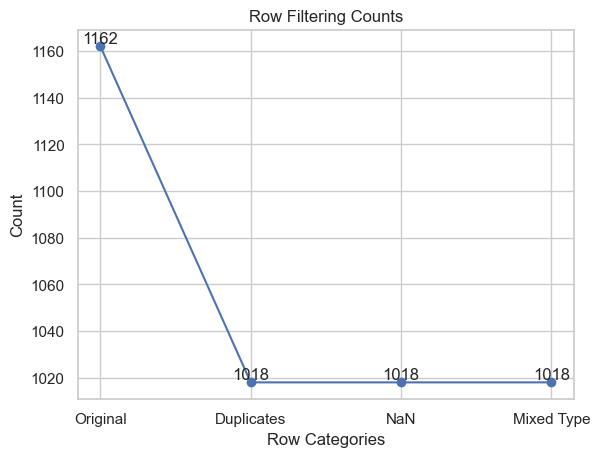

Original row count: 1162
Duplicate rows removed: 144
Rows with NaN values removed: 0
Mixed type rows removed: 0
Final row count after processing: 1018


In [737]:
import matplotlib.pyplot as plt

# Plotting keys and values for the line graph
categories = ['Original', 'Duplicates', 'NaN', 'Mixed Type']
counts = [oldRowCount, duplicateRowCount, nanRowCount, mixedTypeRowCount]

# Updating the changes in count to refect total counts
current = oldRowCount
for i, count in enumerate(counts[1:]):
    current -= count
    counts[i + 1] = current

plt.plot(categories, counts, marker='o', linestyle='-', color='b')  # line with points

# Adding annotations to the plot for better understanding
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')    

plt.title('Row Filtering Counts')
plt.xlabel('Row Categories')
plt.ylabel('Count')
plt.grid(True)  # optional, adds grid for readability
plt.show()

# Displaying the statsistics in text format for precise values
print(f"Original row count: {oldRowCount}")
print(f"Duplicate rows removed: {duplicateRowCount}")
print(f"Rows with NaN values removed: {nanRowCount}")
print(f"Mixed type rows removed: {mixedTypeRowCount}")
print(f"Final row count after processing: {newRowCount}")


Icd_o_3_histology Counts Distribution:
icd_o_3_histology
8070/3    465
8140/3    313
8255/3    107
8550/3     24
8260/3     22
8252/3     19
8480/3     14
8083/3     14
8071/3     13
8230/3      5
8253/3      5
8052/3      4
8507/3      3
8250/3      3
8072/3      3
8310/3      2
8073/3      1
8490/3      1
Name: count, dtype: int64


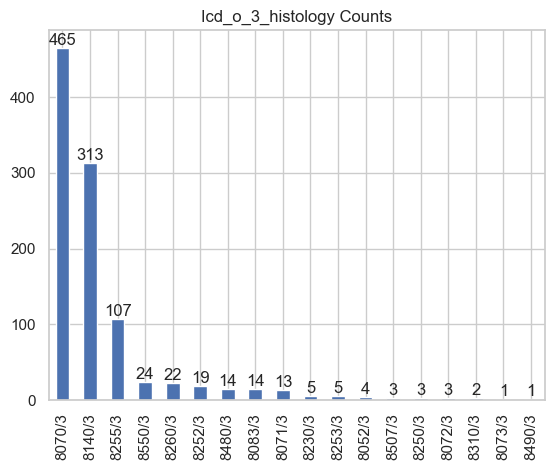

In [738]:
# Plotting the training target column count distribution in graph format
histologyCounts = dataFrame[targetColumn].value_counts()
histologyCounts.plot(kind='bar', title=f'{targetColumn.capitalize()} Counts', xlabel='')

# Adding annotations to the plot for better understanding
for index, value in enumerate(histologyCounts):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Displating the distribution using text format for precision
print(f"\n{targetColumn.capitalize()} Counts Distribution:")
print(histologyCounts)

#### 3. Categorising the histology types

In [739]:
# Initializing the histology column to classify histology types
import numpy as np

# Converting the target column to string type to ensure consistent processing
dataFrame[targetColumn] = dataFrame[targetColumn].astype(str)

# Mapping the category numbers to their respective names for visualization
categoryNameMap: dict[int, str] = {
    0: 'Squamous',
    1: 'Adenocarcinoma',
    2: 'Other'
}   

# Defining sets to identify histology types in each category
squamousCodes: set = set()
adenocarcinomaCodes: set = set()
otherHistologyCodes: set = set()
invalidHistologyCodes: set = set()

# Function looks at the ICD-O-3 histology code and classifies it into one of three categories
def classifyHistology(icdCode: str) -> int:
    global otherHistologyCodes, squamousCodes, adenocarcinomaCodes, invalidHistologyCodes

    try:
        # Retrieving the numerical main code from the ICD-O-3 histology code
        mainCode: int = int(icdCode.split("/")[0])
    except:
        invalidHistologyCodes.add(icdCode)
        return None
    # Squamous
    if  8050 <= mainCode <= 8084:
        squamousCodes.add(icdCode)
        return 0
    # Adenocarcinoma  
    elif 8140 <= mainCode <= 8576:
        adenocarcinomaCodes.add(icdCode)
        return 1 
    
    # Other histology types will be counted as 2 ("Other")
    otherHistologyCodes.add(icdCode)
    return 2

# Dropping possible invalid histology codes
dataFrame.dropna(subset=[targetColumn], inplace=True)

# Classifying histology types and updating the histology column
dataFrame[targetColumn] = dataFrame[targetColumn].apply(classifyHistology).astype("category")

# # Converting the histology column to categorical type for better memory efficiency
# dataFrame[targetColumn] = pd.Categorical(dataFrame[targetColumn]).codes

# # Dropping rows with only one smaple of histology type
# dataFrame = dataFrame[dataFrame[targetColumn].value_counts()[dataFrame[targetColumn]].values > 1]

# Used for mean expression plots
filterdNonNormalizedDF: pd.DataFrame = dataFrame.copy()

# Using log2 to normalize the gene expression data
dataFrame[geneColumns] = np.log2(dataFrame[geneColumns] + 1)

# Saving a copy of the filtered DataFrame
filteredDF: pd.DataFrame = dataFrame.copy()

# Displaying the unique histology types and their counts
print(f'Squamous Codes ({len(squamousCodes)}):', squamousCodes)
print(f'Adenocarcinoma Codes ({len(adenocarcinomaCodes)}):', adenocarcinomaCodes)
print(f'Other Histology Codes ({len(otherHistologyCodes)}):', otherHistologyCodes)
print(f'Invalid Histology Codes ({len(invalidHistologyCodes)}):', invalidHistologyCodes)

Squamous Codes (6): {'8071/3', '8070/3', '8052/3', '8072/3', '8083/3', '8073/3'}
Adenocarcinoma Codes (12): {'8140/3', '8550/3', '8253/3', '8260/3', '8310/3', '8480/3', '8230/3', '8250/3', '8490/3', '8255/3', '8252/3', '8507/3'}
Other Histology Codes (0): set()
Invalid Histology Codes (0): set()


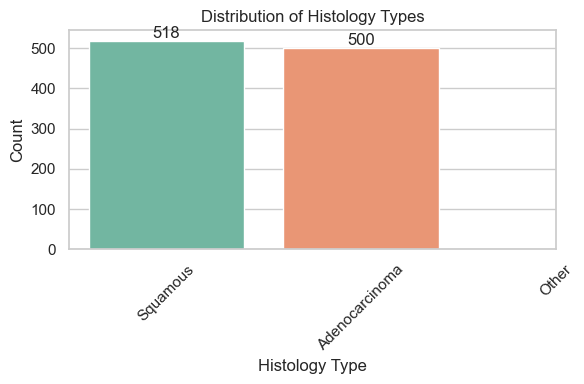

Squamous Count: 500
Adenocarcinoma Count: 518
Other Histology Count: 0


In [740]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting a small graph to visualize the distribution of histology types
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x=dataFrame[targetColumn].astype(str), palette="Set2", hue=dataFrame[targetColumn].astype(str))

# Adding annotations to the plot for better understanding
for index, value in enumerate(dataFrame[targetColumn].value_counts()):
    plt.text(index, value, str(value), ha='center', va='bottom')    

plt.title('Distribution of Histology Types')
plt.xlabel('Histology Type')
plt.ylabel('Count')
plt.xticks(ticks=list(categoryNameMap.keys()), labels=list(categoryNameMap.values()), rotation=45)
plt.tight_layout()
plt.show()

# Displaying the distribution of histology in text format to ensure precision
print('Squamous Count:', dataFrame[targetColumn].value_counts().get(0, 0))
print('Adenocarcinoma Count:', dataFrame[targetColumn].value_counts().get(1, 0))
print('Other Histology Count:', dataFrame[targetColumn].value_counts().get(2, 0))

### 4. Feature Selection

- Feature Reduction
- PCA
- Research Features

#### 4.1. Feature Reduction

Using many different feature reduction methods to find the optimal feature set.

##### 4.1.1 Fraction Threshold

Any genes that where 80% of the sampels have a value lower that 5 wil be dropped, these genes likely do not play a large role in detecting histology subtypes.

In [741]:
featureReductionFeatures: list[str] = geneColumns

# All feature redction changes will be made on this data frame
featureReductionDF: pd.DataFrame = dataFrame

countThreshold: int = 0.5 # TODO find logical value
sampleFractionThreshold: float = 0.9 # TODO find logical value

# Creating a mask for the data frame so only the active genes are included
lowCountmask = (featureReductionDF[featureReductionFeatures] < countThreshold).sum(axis=0) > (sampleFractionThreshold * featureReductionDF[geneColumns].shape[0])

# Creating a filterd data frame containing onlt gene columns that meet the threshold criteria
maskedDataFrame: pd.DataFrame = featureReductionDF[featureReductionFeatures].loc[:, ~lowCountmask]

# Updating the gene columns to ensure correct indexing
featureReductionFeatures = maskedDataFrame.columns

# Joining the original clinical columns with the filtered gene columns
featureReductionDF = featureReductionDF[clinicalColumns].join(maskedDataFrame)

# Adding an entry to the feature selection steps dictionary
featureReductionSteps = {**featureSelectionSteps, "Fraction Threshold": len(featureReductionDF.columns)}

##### 4.1.2. Variance threshold

Small variance between gene samples have litte to no value to the global model training and can be dropped.

In [742]:
from numpy import ndarray
from sklearn.feature_selection import VarianceThreshold

# Define a threshold for variance
varianceThreshold: int = 0.4 # 1  # TODO find logical value

# Step 1: Creating the data frame for the variance threshold to be applied
threshHoldDataFrame: pd.DataFrame = featureReductionDF[featureReductionFeatures]

# Step 2: Appling the VarianceThreshold
selector = VarianceThreshold(threshold=varianceThreshold)
selector.fit(threshHoldDataFrame)

# Step 3: Get selected column names
featureReductionFeatures = threshHoldDataFrame.columns[selector.get_support()]

# Step 4: Updating the data frame with the selected feature columns joined with clinical columns
featureReductionDF = threshHoldDataFrame[featureReductionFeatures].join(featureReductionDF[clinicalColumns])

# Adding an entry to the feature selection steps dictionary
featureReductionSteps["Variance Threshold"] = len(featureReductionDF.columns)

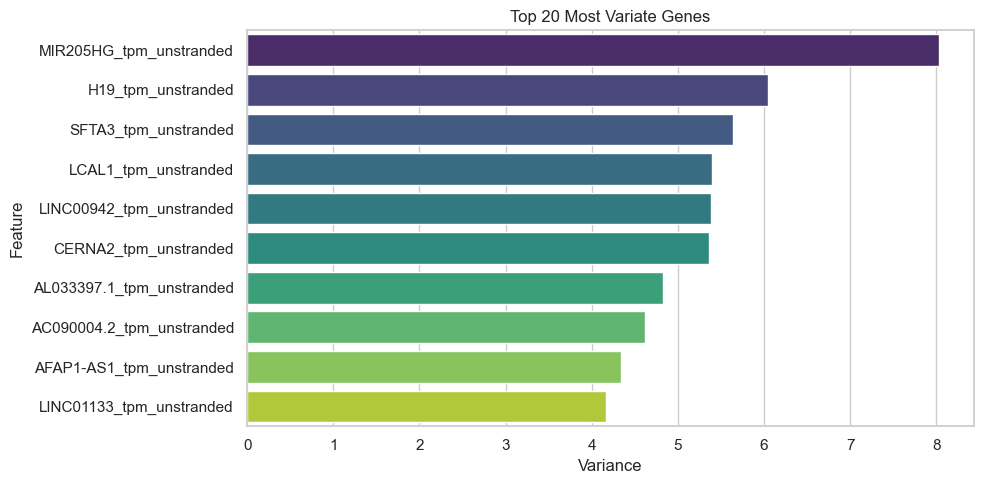

In [743]:
# Retrieving the 10 most variate genes for visualization
plotX = threshHoldDataFrame[featureReductionFeatures].var().sort_values(ascending=False)[:10]

# Plotting the most variate genes to visualize the variance distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=plotX.values, 
    y=plotX.index, palette='viridis', hue=plotX.index, dodge=False)
plt.title('Top 20 Most Variate Genes')
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

##### 4.1.3. Standard scaler (Data split)

In [744]:
from sklearn.preprocessing import StandardScaler

# Splits the DataFrame into features (X) and target (y).
def getDataXAndY(dataFrame: pd.DataFrame, targetColumn: str) -> tuple[pd.DataFrame, pd.Series]:
    # All features except the target
    X = dataFrame.drop(columns=[targetColumn]) 
    # Target variable 
    y = dataFrame[targetColumn]  
    return X, y

# Scales all the features using the StandardScaler.
def scaleFeatures(dataFrame: pd.DataFrame, targetColumn: str) -> pd.DataFrame:
    X, _ = getDataXAndY(dataFrame, targetColumn)
    dataFrame[X.columns] = StandardScaler().fit_transform(X)
    return dataFrame

featureReductionDF = scaleFeatures(featureReductionDF, targetColumn)

##### 4.1.4. Lasso regression

In [745]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Define a threshold for Lasso regularization
lassoThreshold: float = 0.005  # TODO find logical value

XReductionTrain, yReductionTrain = getDataXAndY(featureReductionDF, targetColumn)
print(featureReductionDF[targetColumn].value_counts())

# 1. Fit Lasso and SelectFromModel
lasso: Lasso = Lasso(alpha=lassoThreshold)
selector: SelectFromModel = SelectFromModel(lasso)
selector.fit(XReductionTrain, yReductionTrain)

# 2. Get selected feature mask
lowCountmask: ndarray = selector.get_support()

# 3. Use mask to trim original DataFrame (preserving column names)
featureReductionFeatures = XReductionTrain.columns[lowCountmask]

# 4. join the target column with the filtered gene columns
featureReductionDF = XReductionTrain[featureReductionFeatures].join(yReductionTrain)

# Adding an entry to the feature selection steps dictionary
featureReductionSteps["Lasso Threshold"] = len(featureReductionDF.columns)

icd_o_3_histology
1    518
0    500
Name: count, dtype: int64


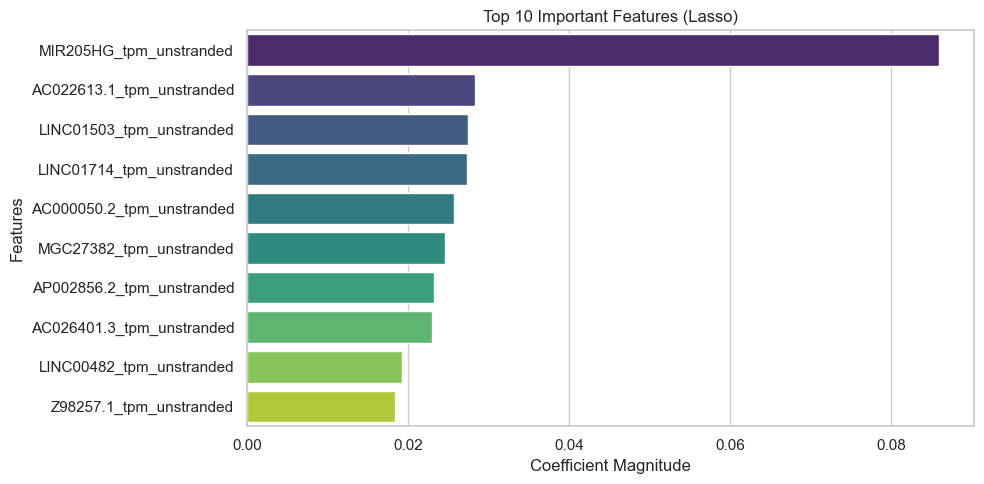

In [746]:
# Plotting the 10 best features based on Lasso coefficients
import matplotlib.pyplot as plt
import numpy as np

# Use real column names from your DataFrame
featureNames: list[str] = XReductionTrain.columns.tolist()

# Absolute coefficients
coefs = np.abs(selector.estimator_.coef_)

# Get indices of top 10 features
topIndices = np.argsort(coefs)[-10:][::-1] 

# Storing the plot y for the plot data and hue
plotX = np.array(featureNames)[topIndices]

# Plot the coefficients of the top 10 features
plt.figure(figsize=(10, 5))
sns.barplot(x=coefs[topIndices], y=plotX,  palette='viridis', hue=plotX, dodge=False)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.title("Top 10 Important Features (Lasso)")
plt.tight_layout()
plt.show()

##### 4.1.5 Correlation threshold

Any correlated features have litte to no extra value to be includeded in model training and can be dropped.

In [747]:
# Defining a threshold for correlation
correlationThreshold: float = 0.75 

# Creating a correlation matrix
correlationMatrix: pd.DataFrame = featureReductionDF[featureReductionFeatures].corr()

# Finding pairs of columns with correlation above the threshold
thresholdColumns = set()
for i in range(len(correlationMatrix.columns)):
    for j in range(i):
        if abs(correlationMatrix.iloc[i, j]) > correlationThreshold:
            colname: str = correlationMatrix.columns[i]
            thresholdColumns.add(colname)

# Dropping the selected columns from the original DataFrame
featureReductionDF.drop(columns=thresholdColumns, inplace=True)

# Updating the geneColumns to reflect the reduced set after correlation thresholding
featureReductionFeatures = getGeneColumns()

# Adding an entry to the feature selection steps dictionary
featureReductionSteps["Correlation Threshold"] = len(featureReductionDF.columns)

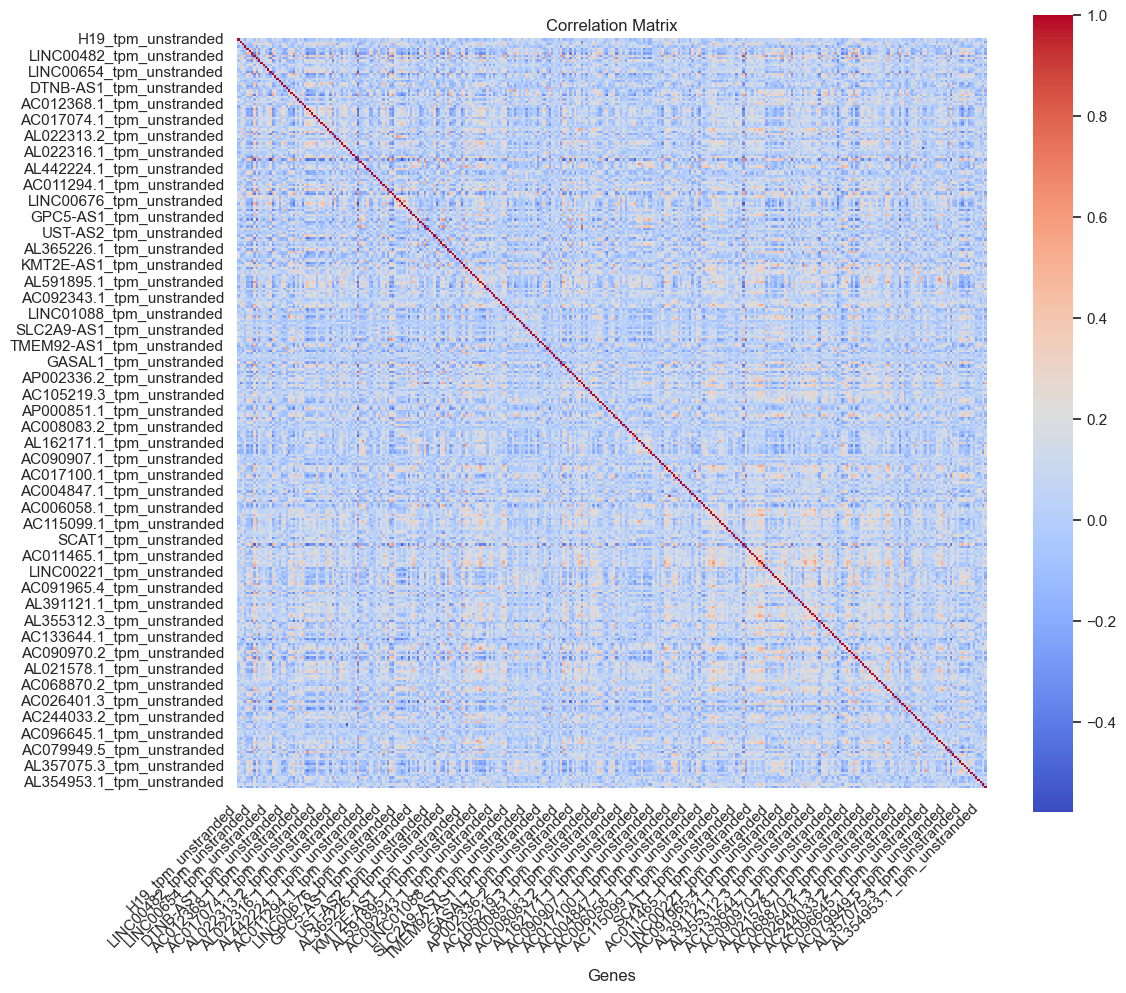

In [748]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlationMatrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.xlabel('Genes')
plt.title('Correlation Matrix')
plt.show()

##### 4.1.6. Select K Best

In [749]:
from numpy import ndarray
from sklearn.feature_selection import SelectKBest, f_classif

kSelectBestThreshold: int = 10  # TODO find logical value

XReductionTrain, yReductionTrain = getDataXAndY(featureReductionDF, targetColumn)

# Creating the SelectKBest selector with the given threshold goal
selector: SelectKBest = SelectKBest(score_func=f_classif, k=kSelectBestThreshold)
selector.fit(XReductionTrain, yReductionTrain)

# Getting the mask of selected features
lowCountmask: ndarray = selector.get_support()
featureReductionFeatures = XReductionTrain.columns[lowCountmask]

# join the target column back
featureReductionDF = XReductionTrain[featureReductionFeatures].join(yReductionTrain)

# Adding an entry to the feature selection steps dictionary
featureReductionSteps["SelectKBest"] = len(featureReductionDF.columns)

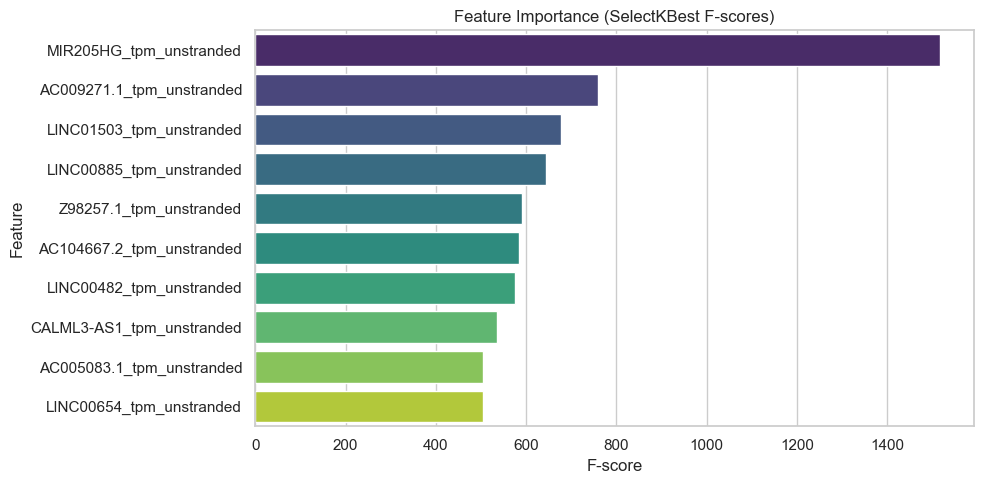

In [750]:
# Convert to DataFrame and sort by score
featureScores: pd.DataFrame = pd.DataFrame({'Feature': XReductionTrain.columns, 'Score': selector.scores_})
featureScores = featureScores.sort_values(by='Score', ascending=False).head(kSelectBestThreshold)

# Plot the features and the corresponding f-scores into a bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=featureScores, x='Score', y='Feature', palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance (SelectKBest F-scores)')
plt.xlabel('F-score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### 4.2. PCA

In [751]:
from sklearn.decomposition import PCA

# Defining the PCA variance threshold
PCAVarianceThreshold: float = 0.4  # TODO find logical value

X, y = getDataXAndY(filteredDF.copy(), targetColumn)

# Apply PCA to the gene expression columns
PCAInstance: PCA = PCA(n_components=PCAVarianceThreshold)
PCATransformed: ndarray = PCAInstance.fit_transform(X)

# Create new DataFrame with PCA-transformed features
PCAFeatures: list[str] = [f'PC{i+1}' for i in range(PCATransformed.shape[1])]
PCADF: pd.DataFrame = pd.DataFrame(PCATransformed, columns=PCAFeatures, index=y.index)

# Join PCA features with the target column
PCADF = PCADF.join(y)

# Scaling the PCA features
PCADF = scaleFeatures(PCADF, targetColumn)

# Creating a PCA specific feature selection steps dictionary
PCASteps: dict[str: int] = {
    **featureSelectionSteps,
    "PCA": len(PCADF.columns)
}

Top 10 features contributing to the first PCA component:
                          feature    weight
6835        MALAT1_tpm_unstranded  0.052413
5573         NEAT1_tpm_unstranded  0.050915
7704    AC136475.3_tpm_unstranded  0.042085
3469     LINC00342_tpm_unstranded  0.041682
2343   ANKRD10-IT1_tpm_unstranded  0.041485
7752    AP006621.2_tpm_unstranded  0.041162
8296    AL928654.2_tpm_unstranded  0.040604
12660   AC084018.1_tpm_unstranded  0.039630
10474   AC110285.2_tpm_unstranded  0.038722
12088   AC015849.3_tpm_unstranded  0.037933


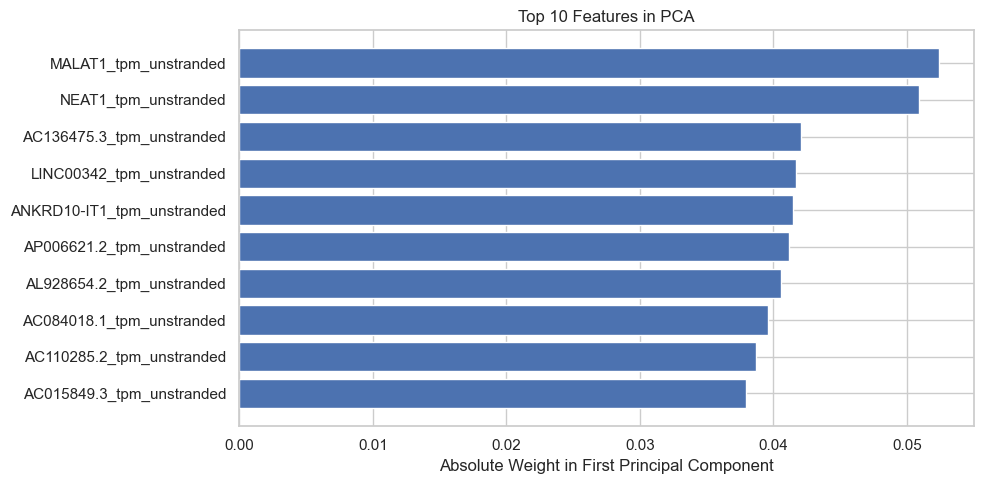

In [752]:
# Get the PCA components (loadings)
pcaComponents: ndarray = PCAInstance.components_

# Number of top features to display
topN: int = 10  

# Create a DataFrame of feature importances
componentDf: pd.DataFrame = pd.DataFrame()
componentDf['feature'] = X.columns
componentDf['weight'] = np.abs(pcaComponents[0])  # Take absolute values for importance

# Sort by absolute weight
componentDf = componentDf.sort_values('weight', ascending=False)

# Display top features
print(f"Top {topN} features contributing to the first PCA component:")
print(componentDf.head(topN))

# Plot top features
plt.figure(figsize=(10, 5))
plt.barh(componentDf['feature'].head(topN)[::-1], componentDf['weight'].head(topN)[::-1])
plt.xlabel('Absolute Weight in First Principal Component')
plt.title(f'Top {topN} Features in PCA')
plt.tight_layout()
plt.show()

# Get the top features from the component DataFrame
topPCAFeatures = componentDf.head(topN)['feature'].values

# Create a DataFrame with just these top features
topPCADF = filteredDF[np.append(topPCAFeatures, targetColumn)]

#### 4.3. Research Features

In [753]:
# Defining the research features to be used in the final model
researchFeatures: list[str] = [
    'MALAT1_tpm_unstranded', 'SNHG1_tpm_unstranded', 'MIR22HG_tpm_unstranded', 
    'HOXA11-AS_tpm_unstranded', 'AC068228.1_tpm_unstranded', 'SATB2-AS1_tpm_unstranded', 
    'LINC01843_tpm_unstranded', 'AL606489.1_tpm_unstranded'
]

# Creating a new DataFrame with only the research features
researchDF: pd.DataFrame = filteredDF[researchFeatures + [targetColumn]].copy()

# Scaling the features in the research DataFrame
researchDF = scaleFeatures(researchDF, targetColumn) 

# Creating a research specific feature selection steps dictionary
researchSteps: dict[str: int] = {
    **featureSelectionSteps,
    "Research Features": len(researchDF.columns)
}

##### 4.4. Reduction Graph

Showing the step in feature selection for the various methods used

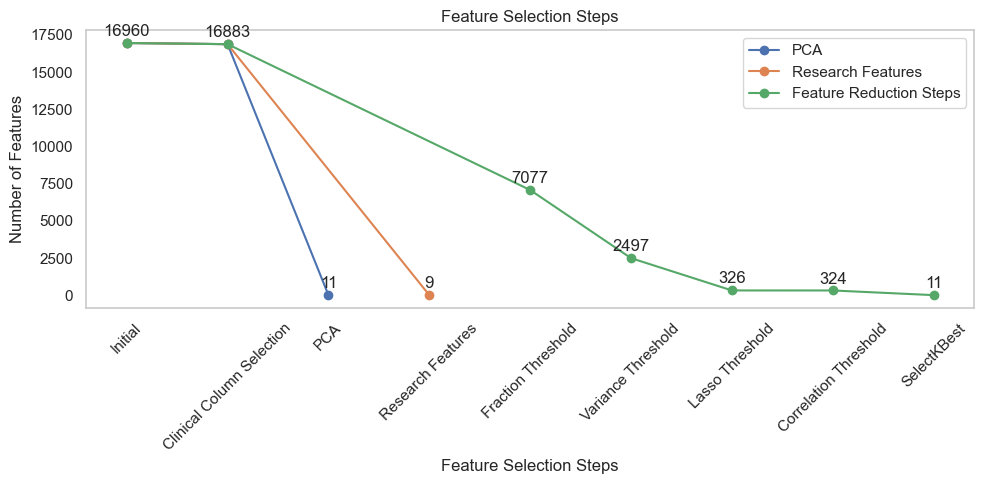

In [754]:
# Plotting a line graph showing the feature selection steps
plt.figure(figsize=(10, 5))

# Function to plot a line graph for feature selection steps
def plotLine(dictData: dict[str, int], keepStart: bool = False) -> None:
    plt.plot(list(dictData.keys()), list(dictData.values()), marker='o')

    # Adding annotations for each point
    for step, count in list(dictData.items())[(0 if keepStart else 2):]:
        plt.annotate(f'{count}', (step, count), textcoords="offset points", xytext=(0, 5), ha='center')


# Plotting the feature selection steps for each method
plotLine(PCASteps, True)
plotLine(researchSteps)
plotLine(featureReductionSteps)  

plt.legend(['PCA', 'Research Features', 'Feature Reduction Steps'], loc='upper right')

plt.title('Feature Selection Steps')
plt.xlabel('Feature Selection Steps')
plt.ylabel('Number of Features')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

#### 4.5. Mean Expression graphs

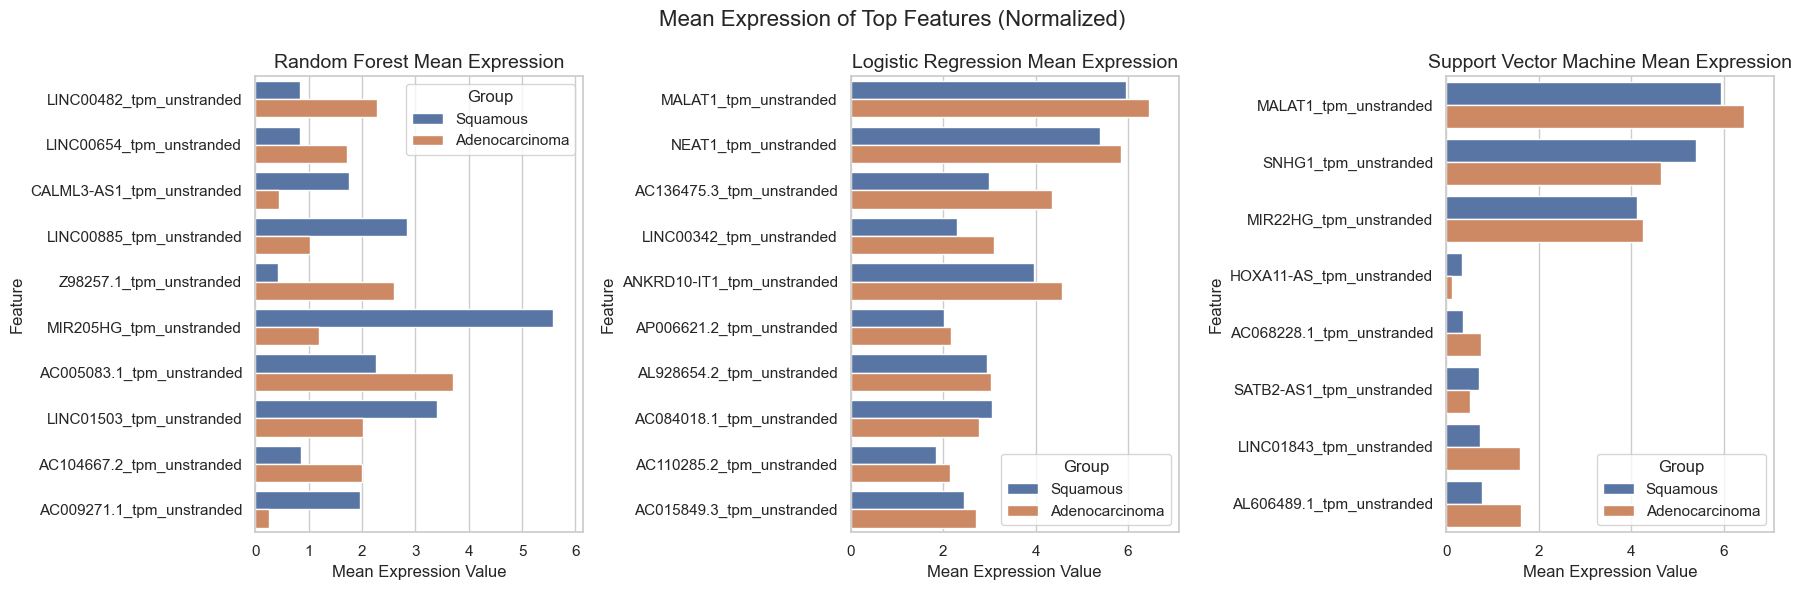

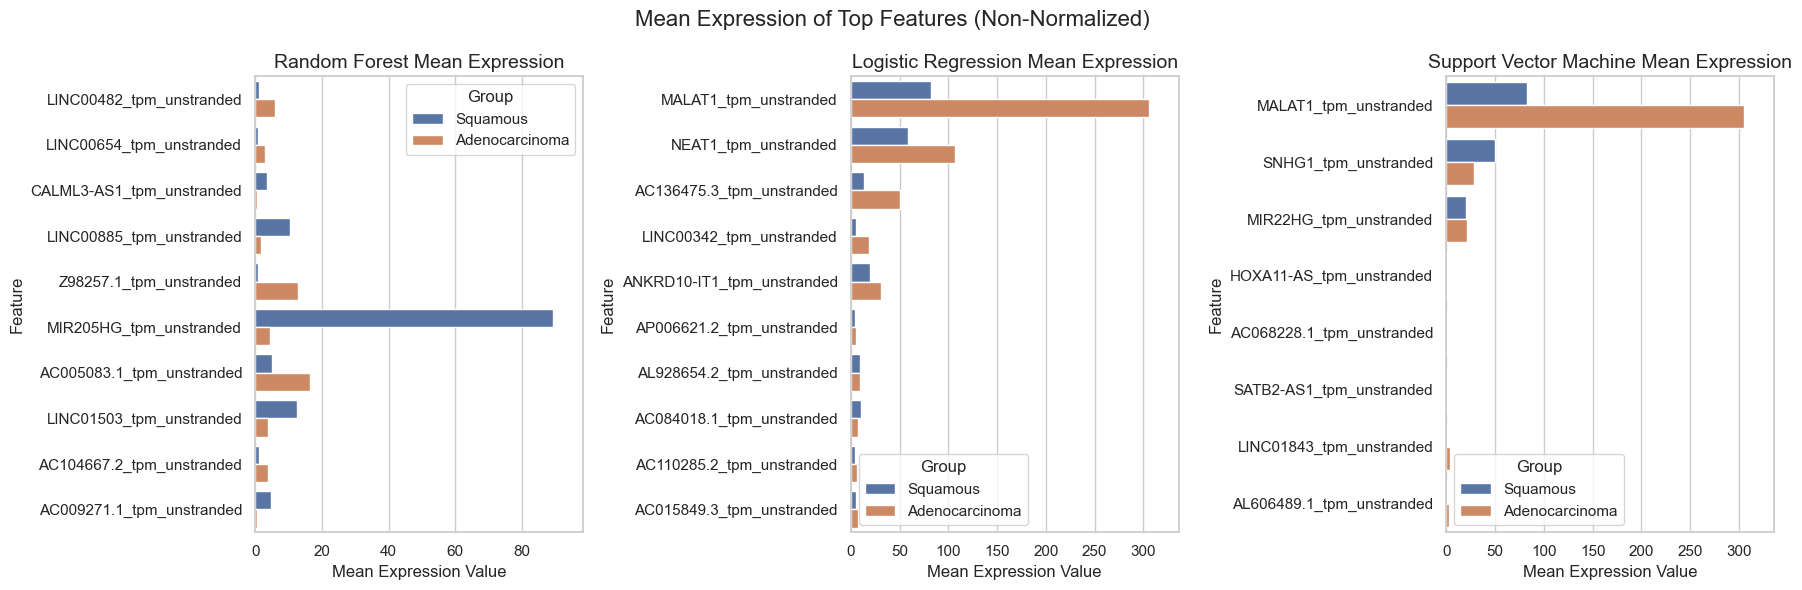

In [755]:
from matplotlib.axes import Axes

# Function that creates a dictionary for feature reduction results
def createDictForFeatureSelection(rfResults: dict[str: object], pcaResults: dict[str: object], svmResults: dict[str: object]) -> dict[str: dict[str: object]]:
    return {
        'Random Forest': rfResults,
        'Logistic Regression': pcaResults,
        'Support Vector Machine': svmResults
    }


# Function to plot the mean expression of the top features by histology type
def plotMeanExpressions(ax: Axes, dataFrame: pd.DataFrame, features: list, title):
    # Calculate mean values for each histology type
    squamousMeans = dataFrame[dataFrame[targetColumn] == 0][features].mean()
    adenocarcinomaMeans = dataFrame[dataFrame[targetColumn] == 1][features].mean()

    # Create a comparison DataFrame
    comparisonDf: pd.DataFrame = pd.DataFrame({
        'feature': features,
        'Squamous': squamousMeans.values, 
        'Adenocarcinoma': adenocarcinomaMeans.values,
    })

    # Melt the DataFrame for easier plotting with seaborn
    meltedDF: pd.DataFrame = pd.melt(comparisonDf, id_vars=['feature'], var_name='group', value_name='meanExpression')

    # Create the plot
    sns.barplot(x='meanExpression', y='feature', hue='group', data=meltedDF, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Mean Expression Value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.legend(title='Group')

    # Set plot horizontal alignment
    ax.set_xlim(0, meltedDF['meanExpression'].max() * 1.1)  # Adjust x-axis limit for better visibility

def plotMeanExpressionsSubplots(data: dict[str: dict[str: object]], title: str) -> None:
    # Creating subplots for the different feature selection methods
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Title for the entire figure
    fig.suptitle(title, fontsize=16)

    # Iterating through the data dictionary to plot each feature selection method
    for i, (name, (dataFrame, features)) in enumerate(data.items()):
        # Plotting the mean expression for each feature selection method
        plotMeanExpressions(axs[i], dataFrame, features, f'{name} Mean Expression')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()    

    # Plotting the mean expression for the different feature selection methods
    plotMeanExpressions(axs[0], filteredDF[featureReductionDF.columns], featureReductionFeatures, 'Feature Reduction Mean Expression')
    plotMeanExpressions(axs[1], topPCADF, topPCAFeatures, 'PCA Mean Expression')
    plotMeanExpressions(axs[2], filteredDF[researchDF.columns], researchFeatures, 'Research Features Mean Expression')

# Plotting the mean expressions of the top features for each feature selection method in normalized format
plotMeanExpressionsSubplots(createDictForFeatureSelection(
    (filteredDF[featureReductionDF.columns], featureReductionFeatures), 
    (topPCADF, topPCAFeatures), 
    (filteredDF[researchDF.columns], researchFeatures)), 
   'Mean Expression of Top Features (Normalized)'
)

# Plotting the mean expressions of the top features for each feature selection method in non-normalized format
plotMeanExpressionsSubplots(createDictForFeatureSelection(
    (filterdNonNormalizedDF[featureReductionDF.columns], featureReductionFeatures), 
    (filterdNonNormalizedDF[topPCADF.columns], topPCAFeatures), 
    (filterdNonNormalizedDF[researchDF.columns], researchFeatures)), 
    'Mean Expression of Top Features (Non-Normalized)'
)

### 5. Model training

In [ ]:
from collections.abc import Callable
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Random state for reproducibility
randomState: int = 462 
# Number of folds for cross-validation 
foldCount: int = 10
# Test size for train-test split
testSize: float = 0.2

# Turn on or off to show the average fold results or the final model results
onlyMainModel: bool = False

# Function to get the test and train split of the model DataFrame
def getTestTrainSplit( randomState: int, testSize: int) -> Callable:
    def inner(modelDF: pd.DataFrame, targetColumn: str) -> tuple[pd.DataFrame, pd.DataFrame]:
        return train_test_split(modelDF, test_size=testSize, random_state=randomState, stratify=modelDF[targetColumn])
    return inner

# Aplying the settings so each feature selection method used the same
spitter: Callable = getTestTrainSplit(randomState, testSize)

# Splitting the model up into test and train set for the different feature selection methods
trainReductionDF, testReductionDF = spitter(featureReductionDF, targetColumn)
trainPCADF, testPCADF = spitter(PCADF, targetColumn)
trainResearchDF, testResearchDF = spitter(researchDF, targetColumn)

# Function to get the best parameters for a given model using GridSearchCV
def getTunedModel(model, X: pd.DataFrame, y: pd.Series, paramGrid: dict | list[dict]) -> tuple[object, dict[str, object]]:
    from sklearn.model_selection import GridSearchCV
    import warnings

    # The scores used for parameter tuning and evaluation
    scoring: tuple[str] = ('accuracy', 'f1', 'recall',)

    # Using GridSearchCV to find the best parameters
    gridSearch: GridSearchCV = GridSearchCV(model, paramGrid, cv=foldCount, scoring=scoring, n_jobs=-1, error_score=np.nan, refit='f1')
    
    # Suppressing warnings during the fitting process because some models may generate warnings during hyperparameter tuning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gridSearch.fit(X, y)

    # Return the best estimator
    return (gridSearch.best_estimator_, gridSearch.best_params_)

# Function to create a results dictionary to store evaluation metrics
def createResultsDict() -> dict[str, object]:
    return {
        'test_score': [],
        'roc_curves': [],
        'confusion_matrices': [],
        'feature_importances': [],
        'classification_reports': [],
        'shap_values': [],
        'average_feature_importance': None,
        'average_shap_values': None,
    }

# Function to train the model and evaluate its performance
def trainModel(model, XTrain: pd.DataFrame, XTest: pd.DataFrame, yTrain: pd.Series, yTest: pd.Series, results: dict[str:int]) -> object:
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report

    # Training the model based on the current fold
    model.fit(XTrain, yTrain)

    # Predict probabilities for the positive class
    yScore = model.predict_proba(XTest)[:, 1]  # Positive class

    # Check if the model has a feature_importances_ attribute
    hasFeatureImportances: bool = hasattr(model, 'feature_importances_')
    hasCoefficients: bool = hasattr(model, 'coef_')
    hasRocPredictions: bool = hasattr(model, 'predict_proba')

    # Scoring the model on the test set
    results['test_score'].append(model.score(XTest, yTest))  

    # Storing the classification report
    results['classification_reports'].append(classification_report(yTest, model.predict(XTest), output_dict=True))

    # Checking if the model has support for ROC curves
    if hasRocPredictions:
        results['roc_curves'].append(roc_curve(yTest, yScore))

    # Calculate confusion matrix
    results['confusion_matrices'].append(pd.crosstab(yTest, model.predict(XTest), rownames=['Actual'], colnames=['Predicted']))

    # If the model has feature importances, ro coefficients, or neither, we handle them accordingly
    data: list[float] | None = None
    if hasFeatureImportances:
        data = (model.feature_importances_, 'Importance')
    elif hasCoefficients:
        data = (model.coef_[0], 'Coefficient')

    # If the model has feature importances or coefficients, store them  
    if data is not None:
        results['feature_importances'].append(pd.DataFrame(data[0], index=XTrain.columns, columns=[data[1]]).sort_values(data[1], ascending=False))      

    # Creating an explainer for SHAP values
    explainer: shap.Explainer = shap.Explainer(model, XTrain)

    # Checking if the class is TreeExplainer to determine if feature importances are available
    isTreeExplainer: bool = isinstance(explainer, shap.TreeExplainer)
    shapValues = explainer(XTest, check_additivity=False) if isTreeExplainer else explainer(XTest)

    # Store the SHAP values
    results['shap_values'].append((shapValues, XTest))   

# Function that evaluates any model's performance
def modelScore(model, trainDF: pd.DataFrame, testDF: pd.DataFrame, targetColumn: str, onlyMain: bool) -> dict[str, object]:
    from sklearn.model_selection import StratifiedKFold

    # Creating a results dictionary to store evaluation metrics
    results: dict[str, object] = createResultsDict()

    # Creating a StratifiedKFold object for cross-validation
    cv: StratifiedKFold = StratifiedKFold(n_splits=foldCount, shuffle=True, random_state=randomState)

    # Spliting the training data into features (X) and target (y)
    XTrain, yTrain = getDataXAndY(trainDF, targetColumn)

    # This makes sure the correct results are added to the results dictionary
    if onlyMain:
        XTest, yTest = getDataXAndY(testDF, targetColumn)
        # Train the model on the entire training set
        trainModel(model, XTrain, XTest, yTrain, yTest, results)
    else:
        # Manual cross-validation loop
        for trainIdx, testIdx in cv.split(XTrain, yTrain):
            # Train the model and evaluate its performance
            trainModel(model, XTrain.iloc[trainIdx], XTrain.iloc[testIdx], yTrain.iloc[trainIdx], yTrain.iloc[testIdx], results)

    # Calculate the average confusion matrix
    results['average_confusion_matrix'] = sum(results['confusion_matrices']) / len(results['confusion_matrices'])

    # Calculate the average feature importances
    if len(results['feature_importances']) > 0:
        results['average_feature_importance'] = pd.concat(results['feature_importances']).groupby(level=0).mean()

    # Initialize new report
    avgReport: dict = {}
    reports: list = results['classification_reports']

    # Average per-class metrics
    for label in [key for key in reports[0].keys() if key not in ('accuracy',)]:
        avgReport[label] = {
            metric: np.mean([rep[label][metric] for rep in reports])
            for metric in reports[0][label]
        }

    # Adding the averaged classification report to results
    results['average_classification_report'] = reports[0] # avgReport         

    if len(results['shap_values']) > 0:
        # allShapValues = np.vstack(results['shap_values'])
        #np.mean(np.abs(allShapValues), axis=0)
        results['average_shap_values'] = results['shap_values'][0]     
    
    return results

# Function to retrieve the feature matrix (X) and target vector (y) for ech feature selection method
XReductionTrain, yReductionTrain = getDataXAndY(trainReductionDF, targetColumn)
XPCATrain, yPCATrain = getDataXAndY(trainPCADF, targetColumn)
XResearchTrain, yResearchTrain = getDataXAndY(trainResearchDF, targetColumn)

# Runs model parameter tuning and evaluation for a given model
def getModelResults(targetColumn: str, onlyMainModel: bool) -> Callable:
    def inner(model, XTrain: pd.DataFrame, yTrain: pd.Series, trainDF: pd.DataFrame, testDF: pd.Series, paramGrid: dict[str, list]) -> dict[str, object]:
        model, modelParams = getTunedModel(model, XTrain, yTrain, paramGrid)
        results: dict[str: object] = modelScore(model, trainDF, testDF, targetColumn, onlyMainModel)
        print(f"Parameters: {modelParams}")
        return results
    return inner

# Function to retrieve the model results for each feature selection method
modelEvaluator: Callable = getModelResults(targetColumn, onlyMainModel)

# Training the Random Forest Classifier
rf = RandomForestClassifier(random_state=randomState)
rfParamGrid: dict[str: list] = {
    'n_estimators': [75, 100, 125],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}

# Training the Random Forest model and evaluating its performance
print("Training Random Forest Classifier...")
rfReductionResults: dict[str: object] = modelEvaluator(rf, XReductionTrain, yReductionTrain, trainReductionDF, testReductionDF, rfParamGrid)
rfPCAResults: dict[str: object] = modelEvaluator(rf, XPCATrain, yPCATrain, trainPCADF, testPCADF, rfParamGrid)
rfResearchResults: dict[str: object] = modelEvaluator(rf, XResearchTrain, yResearchTrain, trainResearchDF, testResearchDF, rfParamGrid)

# Training a Logistic Regression model
logReg = LogisticRegression(random_state=randomState)
logRegParamGrid: list[dict[str: list]] = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [100, 200]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['saga'],
        'max_iter': [100, 200]
    },

]

# Training the Logistic Regression model and evaluating its performance
print("Training Logistic Regression Classifier...")
logRegReductionResults: dict[str: object] = modelEvaluator(logReg, XReductionTrain, yReductionTrain, trainReductionDF, testReductionDF, logRegParamGrid)
logRegPCAResults: dict[str: object] = modelEvaluator(logReg, XPCATrain, yPCATrain, trainPCADF, testPCADF, logRegParamGrid)
logRegResearchResults: dict[str: object] = modelEvaluator(logReg, XResearchTrain, yResearchTrain, trainResearchDF, testResearchDF, logRegParamGrid)

# Train a Support Vector Machine (SVM) model
svm = SVC(random_state=randomState, probability=True)
smvParamGrid: dict[str: list] = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100],
    'max_iter': [750, 1000, 1250],
    'class_weight': [None, 'balanced'],
}

# Training the SVM model and evaluating its performance
print("Training Support Vector Machine Classifier...")
svmReductionResults: dict[str: object] = modelEvaluator(svm, XReductionTrain, yReductionTrain, trainReductionDF, testReductionDF, smvParamGrid)
svmPCAResults: dict[str: object] = modelEvaluator(svm, XPCATrain, yPCATrain, trainPCADF, testPCADF, smvParamGrid)
svmResearchResults: dict[str: object] = modelEvaluator(svm, XResearchTrain, yResearchTrain, trainResearchDF, testResearchDF, smvParamGrid)

Training Random Forest Classifier...


### 6. Model evaluation

#### 6.1. Model Scores

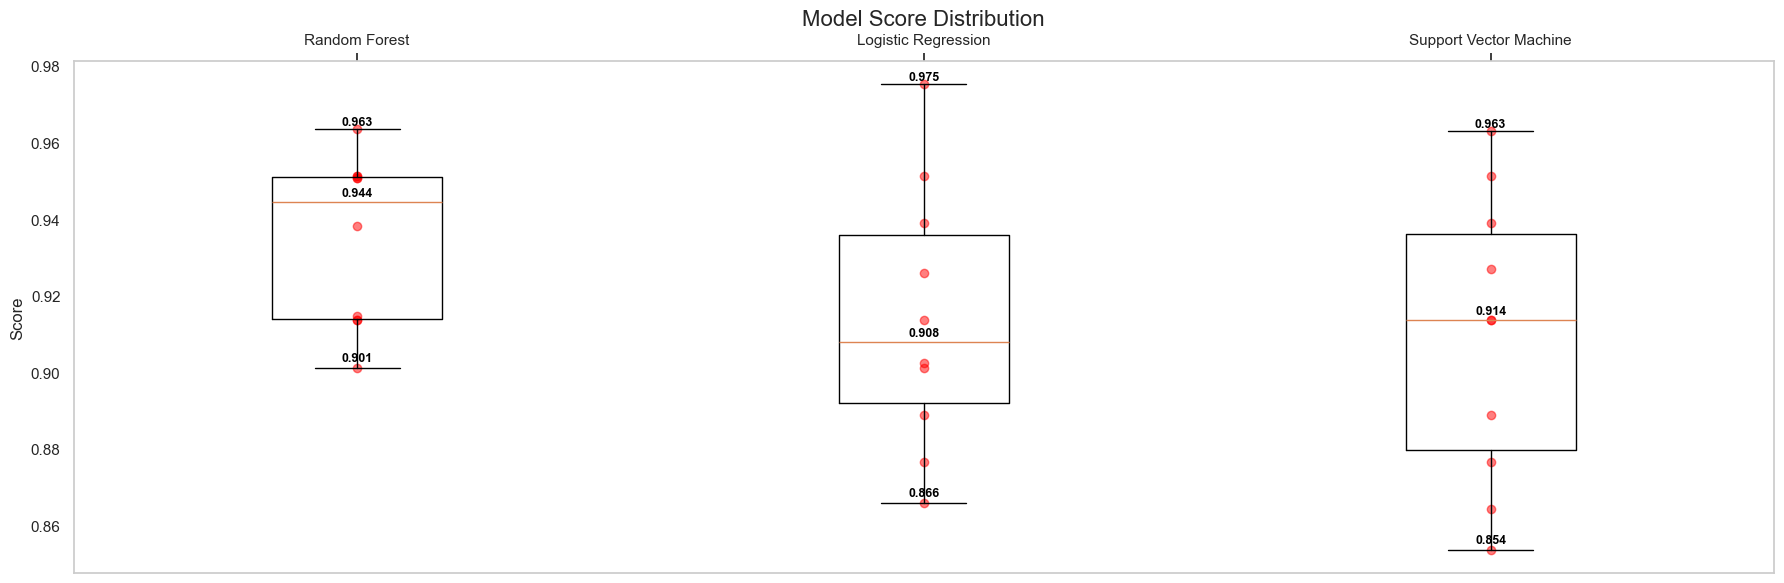

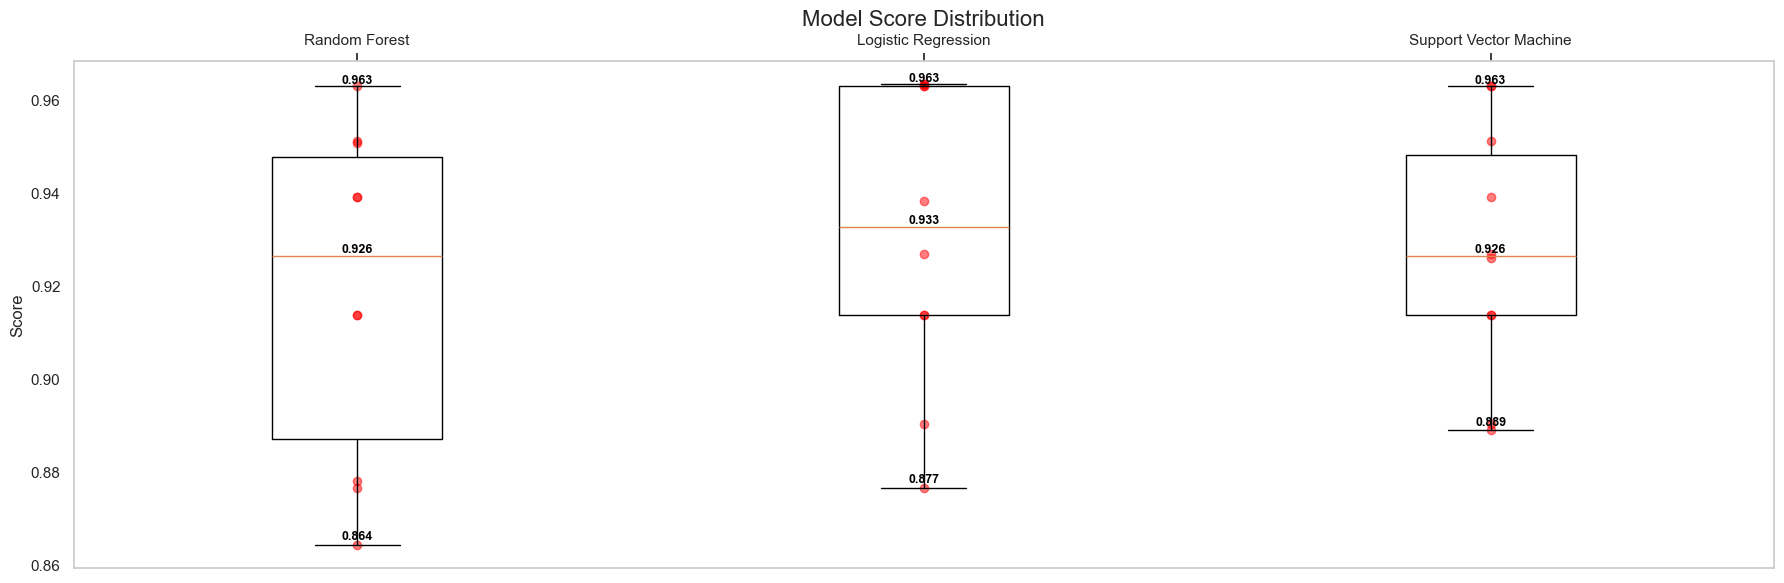

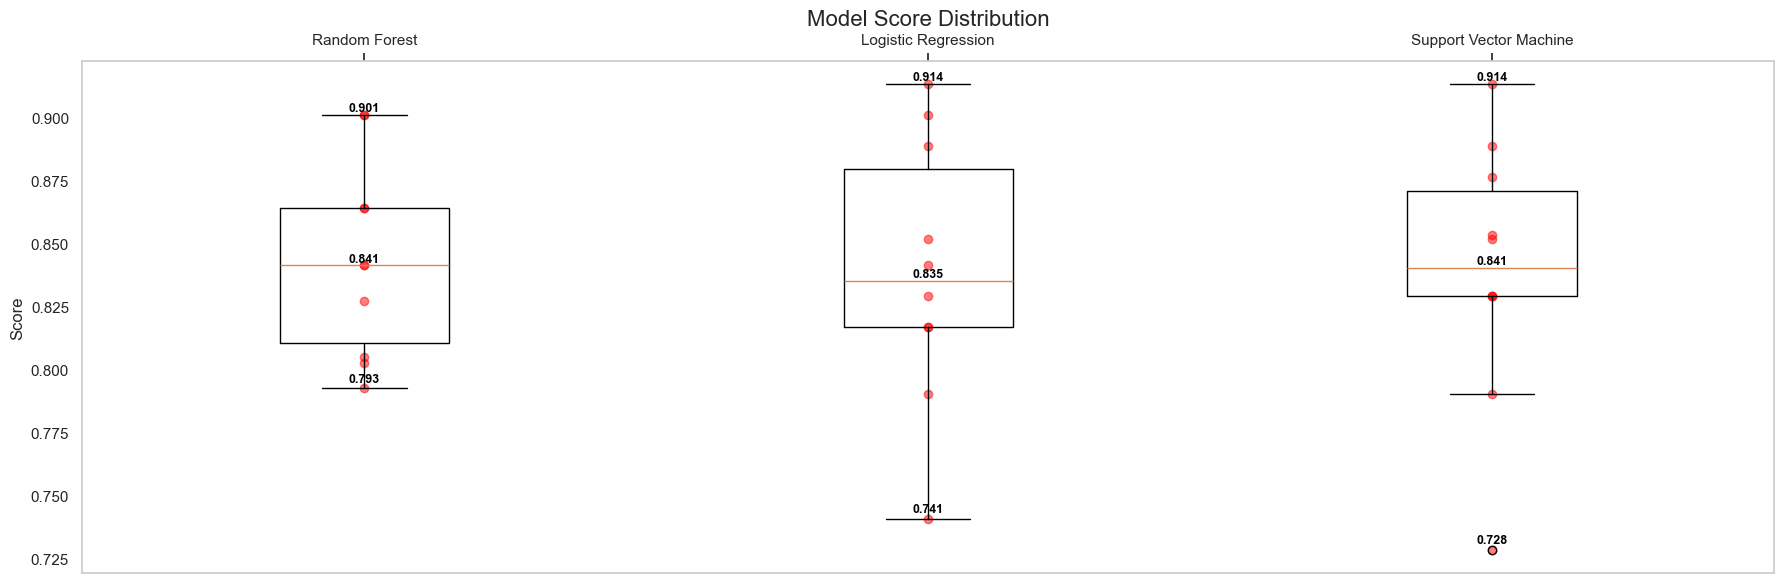


Feature Reduction Model Scores:
Random Forest Scores (0.9444444444444444): [0.9512195121951219, 0.9634146341463414, 0.9146341463414634, 0.9512195121951219, 0.9506172839506173, 0.9012345679012346, 0.9135802469135802, 0.9382716049382716, 0.9135802469135802, 0.9506172839506173]
Logistic Regression Scores (0.9080096356519121): [0.9024390243902439, 0.9512195121951219, 0.8658536585365854, 0.9390243902439024, 0.9753086419753086, 0.8888888888888888, 0.9135802469135802, 0.9259259259259259, 0.8765432098765432, 0.9012345679012346]
Support Vector Machine Scores (0.9135802469135802): [0.926829268292683, 0.9512195121951219, 0.8536585365853658, 0.9390243902439024, 0.9629629629629629, 0.8765432098765432, 0.8641975308641975, 0.9135802469135802, 0.8888888888888888, 0.9135802469135802]

PCA Model Scores:
Random Forest Scores (0.9263023185787413): [0.9512195121951219, 0.9390243902439024, 0.8780487804878049, 0.9390243902439024, 0.9135802469135802, 0.8765432098765432, 0.9135802469135802, 0.9506172839506173

In [ ]:
from numpy import median

# Function that plots a dictionary of model scores
def boxPlotModelScores(results: dict[str: dict[str: object]], title: str) -> None:
    # Ticks for the x-axis based on the keys of the results dictionary
    keys: list[str] = list(results.keys())

    # Extracting the values from the scores dictionary
    scores: list[list[float]] = [score['test_score'] for score in list(results.values())] 

    # Plotting the box plot of model scores
    plt.figure(figsize=(18, 6))
    plt.boxplot(scores, vert=True, tick_labels=keys)
    plt.title('Model Score Distribution', fontsize=16)
    
    # Displaying all the datapoints recieved from the cross-validation scores
    for i, score in enumerate(scores):
        plt.scatter([i + 1] * len(score), score, color='red', alpha=0.5)

    # Function that adds anotations to the box plot for median, min, and max values
    def plotTextualValues(scores: list[float]):
        yOffset = (max(scores) - min(scores)) * 0.02  # dynamic offset based on range
        
        # Adding text annotations for each score
        for i, value in enumerate(scores):
            valueRounded = round(value, 3)
            plt.text(
                i + 1,
                value + yOffset,
                str(valueRounded),
                ha='center',
                va='bottom',
                fontsize=9,
                color='black',
                weight='bold'
            )

    # Displaying the median values for each model on the box plot
    plotTextualValues([median(score) for score in scores])

    # Displaying the minimum and maximum values for each model on the box plot
    plotTextualValues([min(score) for score in scores])
    plotTextualValues([max(score) for score in scores])

    # Move x-axis ticks and label to the top
    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    plt.ylabel('Score')
    plt.grid()
    plt.tight_layout() 
    plt.show()    

# Plotting the model scores for feature reduction
reductionScores: dict[str: dict[str: object]] = createDictForFeatureSelection(rfReductionResults, logRegReductionResults, svmReductionResults)
boxPlotModelScores(reductionScores, 'Model Scores for Feature Reduction')  

# Plotting the model scores for PCA
PCAScores: dict[str: dict[str: object]] = createDictForFeatureSelection(rfPCAResults, logRegPCAResults, svmPCAResults)
boxPlotModelScores(PCAScores, 'Model Scores for PCA')

# Plotting the model scores for research features
researchScores: dict[str: dict[str: object]] = createDictForFeatureSelection(rfResearchResults, logRegResearchResults, svmResearchResults)
boxPlotModelScores(researchScores, 'Model Scores for Research Features')

# Function to print the scores of the models in a readable format
def printScores(scores: dict[str: dict[str: object]], title) -> None:
    print(f"\n{title}:")
    for model, result in scores.items():
        print(f"{model} Scores ({median(result['test_score'])}): {result['test_score']}")


# Printing scores for feature reduction, PCA, and research features
printScores(reductionScores, "Feature Reduction Model Scores")
printScores(PCAScores, "PCA Model Scores")
printScores(researchScores, "Research Features Model Scores")

#### 6.2. Confusions Matrixces

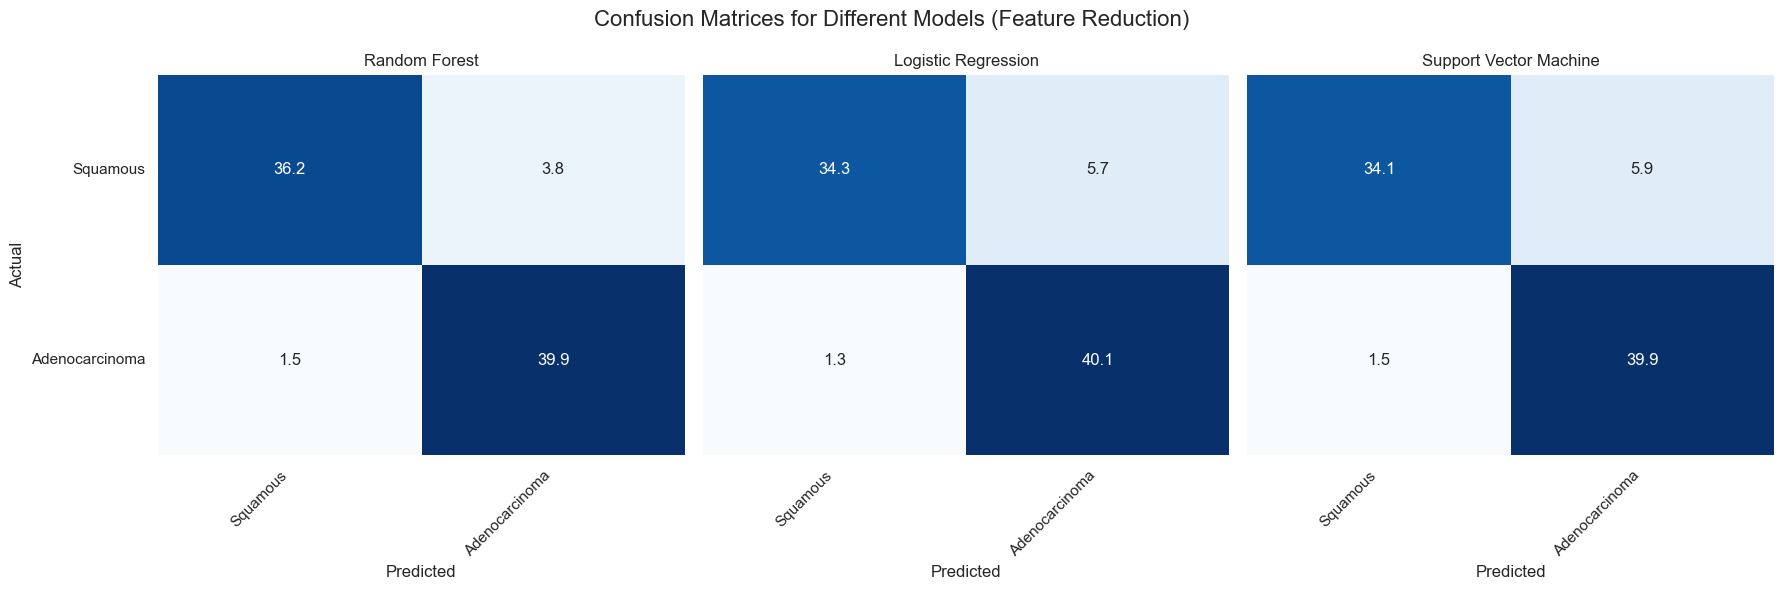

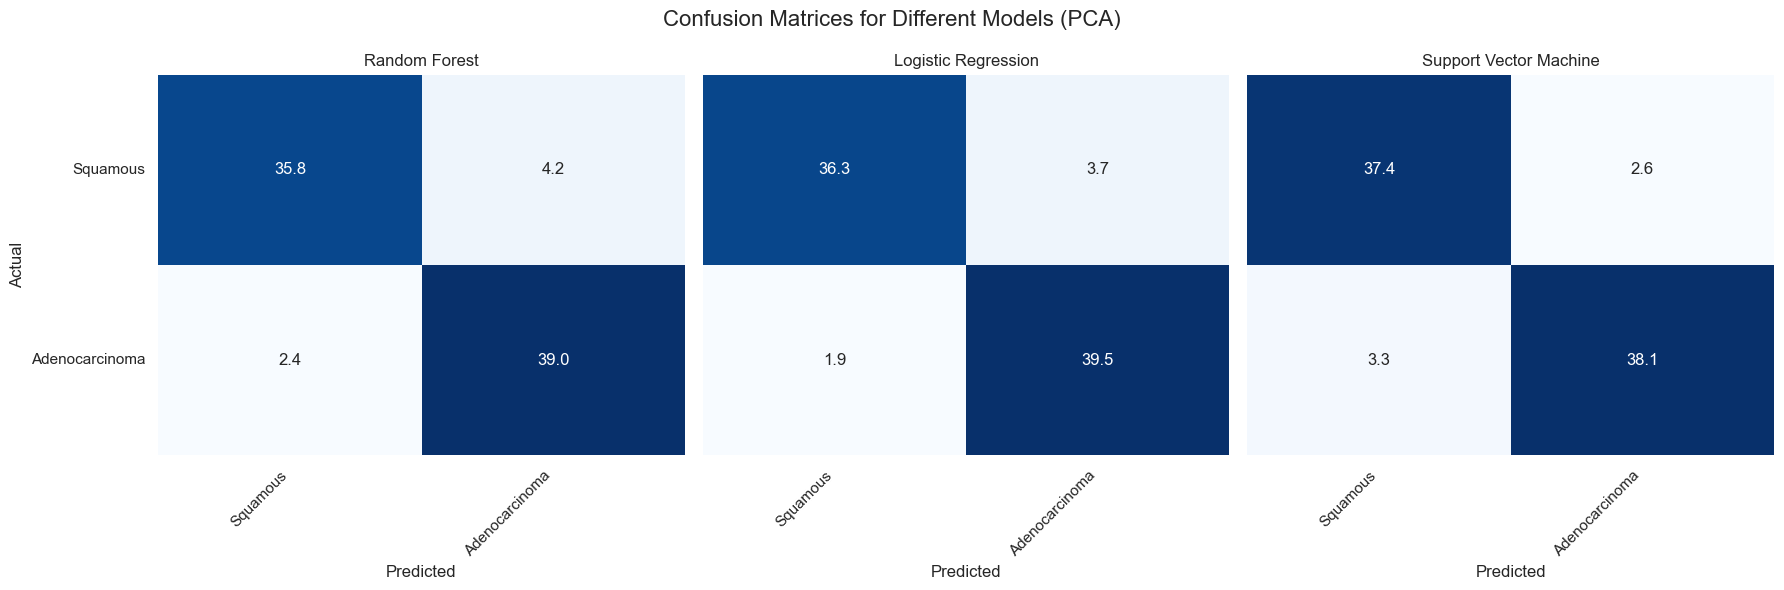

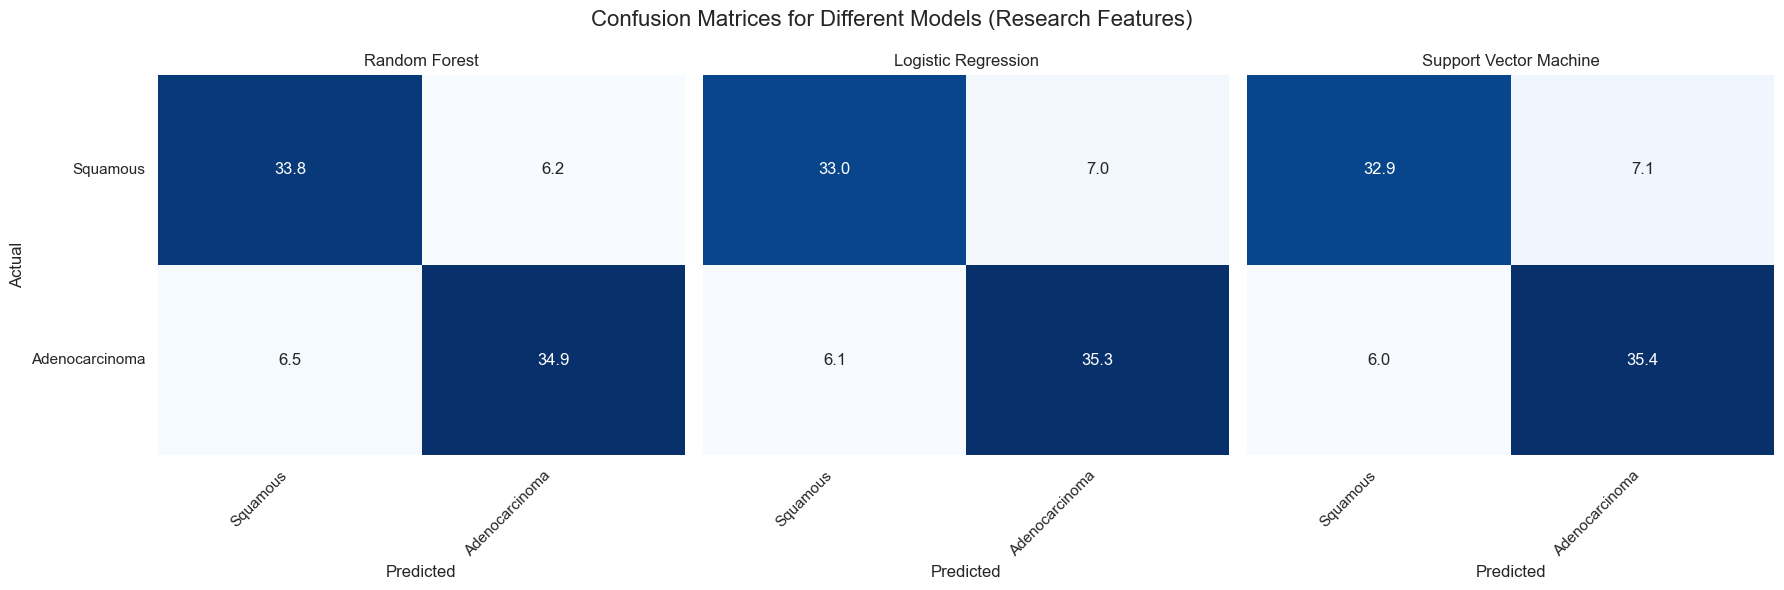

In [ ]:
from matplotlib.axes import Axes

# Function that displays any given confusion matrix on a specified axis
def plotConfusionMatrix(ax: Axes, results, name: str = 'Confusion Matrix', showYLabels: bool = False) -> None:
    averageConfusionMatrix: pd.DataFrame = results['average_confusion_matrix']

    # Plotting the confusion matrix using seaborn's heatmap
    sns.heatmap(averageConfusionMatrix, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)

    # Creating a list of ticks and making sure only the included categories are displayed
    ticks: list[str] = [categoryNameMap.get(int(label), label) for label in averageConfusionMatrix.index]

    # Displaying the ticks on both axes
    ax.set_xticklabels(ticks, rotation=45, ha='right')
    ax.set_yticklabels(ticks, rotation=0)

    # Used for fine control and less redundant labels
    if not showYLabels:
        ax.set_ylabel('')
        ax.set_yticklabels([])

# Function to plot confusion matrices for different models in a subplot
def plotConfusionMatrixSubPlot(matrices: dict[str, dict], kind: str):
    # Creating a subplot figure with 3 columns for each model's confusion matrix
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Title for the entire figure
    fig.suptitle(f'Confusion Matrices for Different Models ({kind})', fontsize=16)

    # Plotting each confusion matrix in its respective subplot
    for i, (modelName, results) in enumerate(matrices.items()):
        plotConfusionMatrix(ax[i], results, modelName, showYLabels=(i == 0))

    plt.tight_layout()
    plt.show()

# Plotting the confusion matrices for the feature reduction method
plotConfusionMatrixSubPlot(createDictForFeatureSelection(
    rfReductionResults, logRegReductionResults, svmReductionResults), 'Feature Reduction')

# Plotting the confusion matrices for the PCA method
plotConfusionMatrixSubPlot(createDictForFeatureSelection(
        rfPCAResults, logRegPCAResults, svmPCAResults), 'PCA')

# Plotting the confusion matrices for the research features method
plotConfusionMatrixSubPlot(createDictForFeatureSelection(
    rfResearchResults, logRegResearchResults, svmResearchResults), 'Research Features')


#### 6.3. Feature Importances and Coefficients

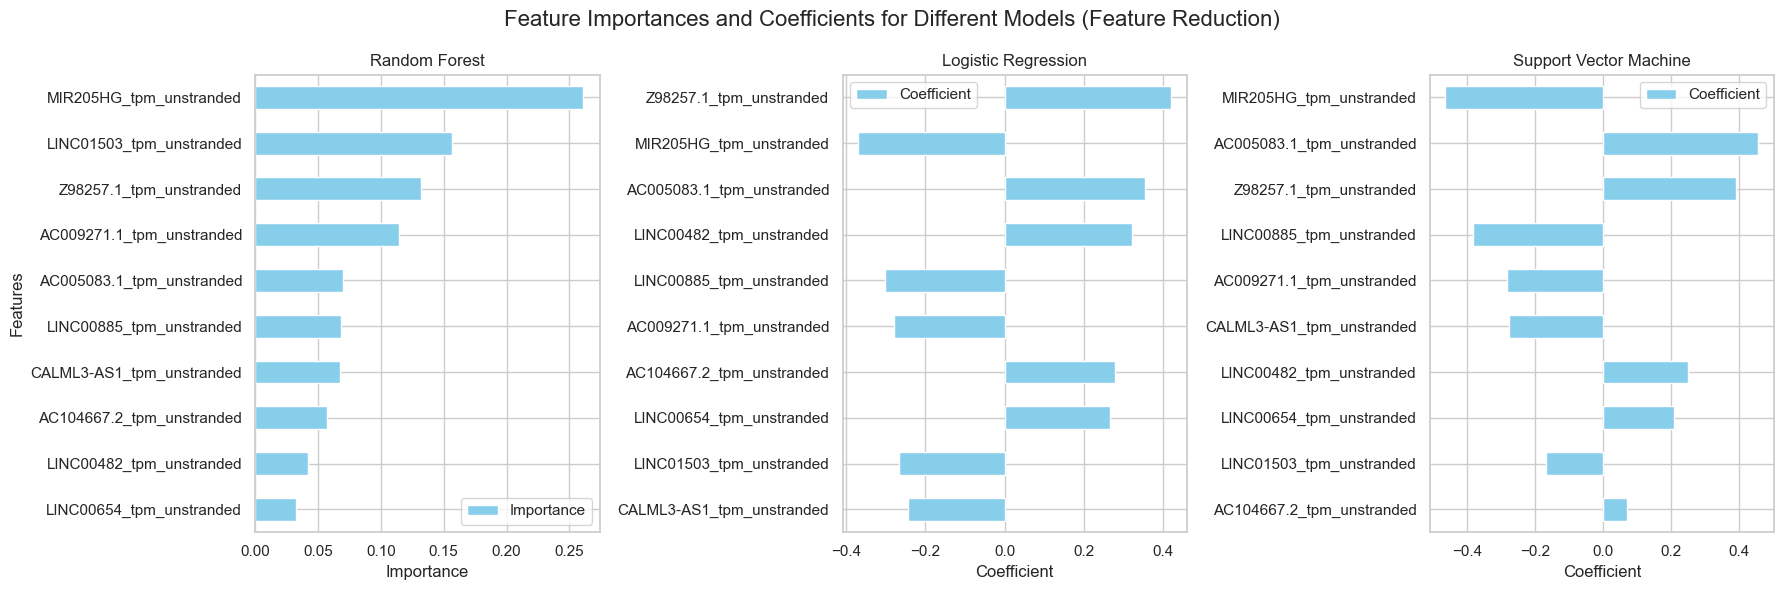

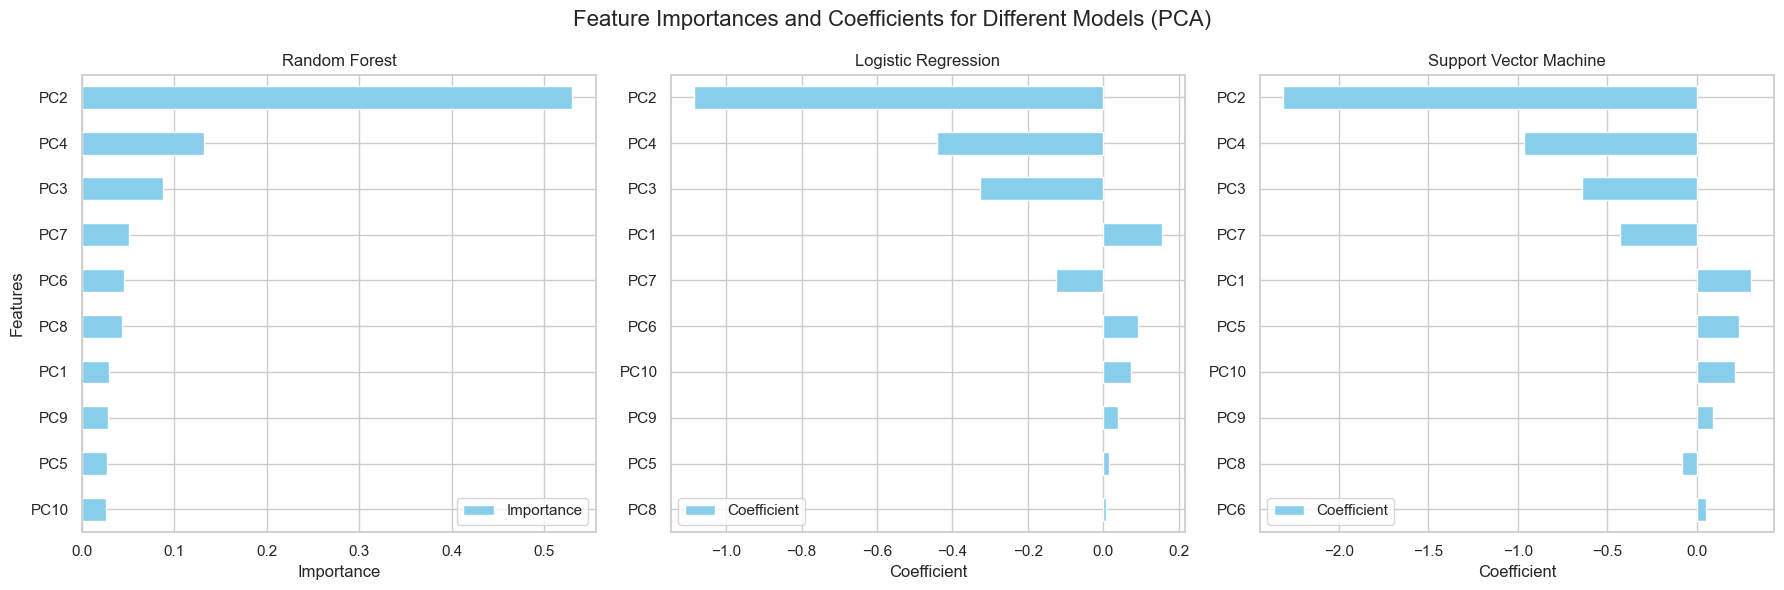

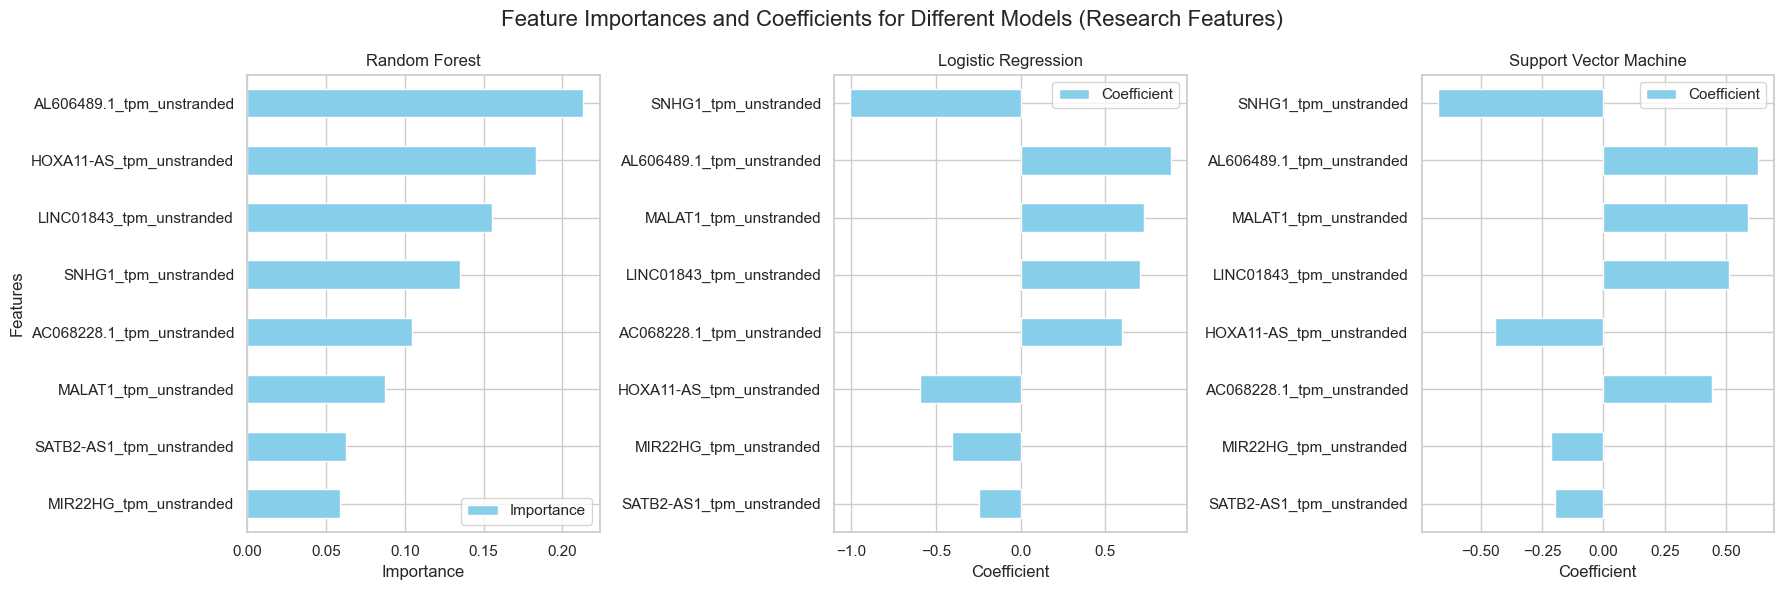

In [ ]:
# Function that displays a bar chart of the feature importances for a given model
def plotFeatureImportances(ax: Axes, results, name: str = 'Feature Importances', showYLabels: bool = False) -> None:
    # All plots will have a tile even if they are empty
    ax.set_title(name)

    # Checking if the model has supported for feature importances
    importances: list[float] | None = results['average_feature_importance']
    if importances is not None and not importances.empty:
        # Retrieving the unique column name for sorting
        columnName: str = importances.columns[0] if not importances.empty else 'Importance'

        # Sorting the importances by the specified column name
        importances = importances.sort_values(by=columnName, ascending=True, key=lambda x: abs(x))

        # Plotting the feature importances using the internal pandas plotting function
        importances.plot(kind='barh', ax=ax, color='skyblue')
       
        # Specificly setting the x-axis label to the column name
        ax.set_xlabel(columnName)

        # Used for fine control and less redundant labels
        if showYLabels:
            ax.set_ylabel('Features')
    else:
        # Schowing a message if there are no feature importances available
        ax.text(0.5, 0.5, 'No feature importances available', horizontalalignment='center', verticalalignment='center', fontsize=12)

        # Hiding the x and y axis ticks for the empty plot
        ax.set_xticks([])
        ax.set_yticks([])


# Function to plot feature importances for different models in a subplot
def plotConfusionImportancesSubPlot(importances: dict[str, dict], kind: str):
    # Creating a subplot figure with 3 columns for each model's feature importances
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Title for the entire figure
    fig.suptitle(f'Feature Importances and Coefficients for Different Models ({kind})', fontsize=16)

    # Plotting each feature importance in its respective subplot
    for i, (modelName, results) in enumerate(importances.items()):
        plotFeatureImportances(ax[i], results, modelName, showYLabels=(i == 0))

    plt.tight_layout()
    plt.show()

# Plotting the feature importances for the feature reduction method
plotConfusionImportancesSubPlot(createDictForFeatureSelection(
    rfReductionResults, logRegReductionResults, svmReductionResults), 'Feature Reduction')

# Plotting the feature importances for the PCA method
plotConfusionImportancesSubPlot(createDictForFeatureSelection(
        rfPCAResults, logRegPCAResults, svmPCAResults), 'PCA')

# Plotting the feature importances for the research features method
plotConfusionImportancesSubPlot(createDictForFeatureSelection(
    rfResearchResults, logRegResearchResults, svmResearchResults), 'Research Features')

#### 6.4. Roc Curves (AUC)

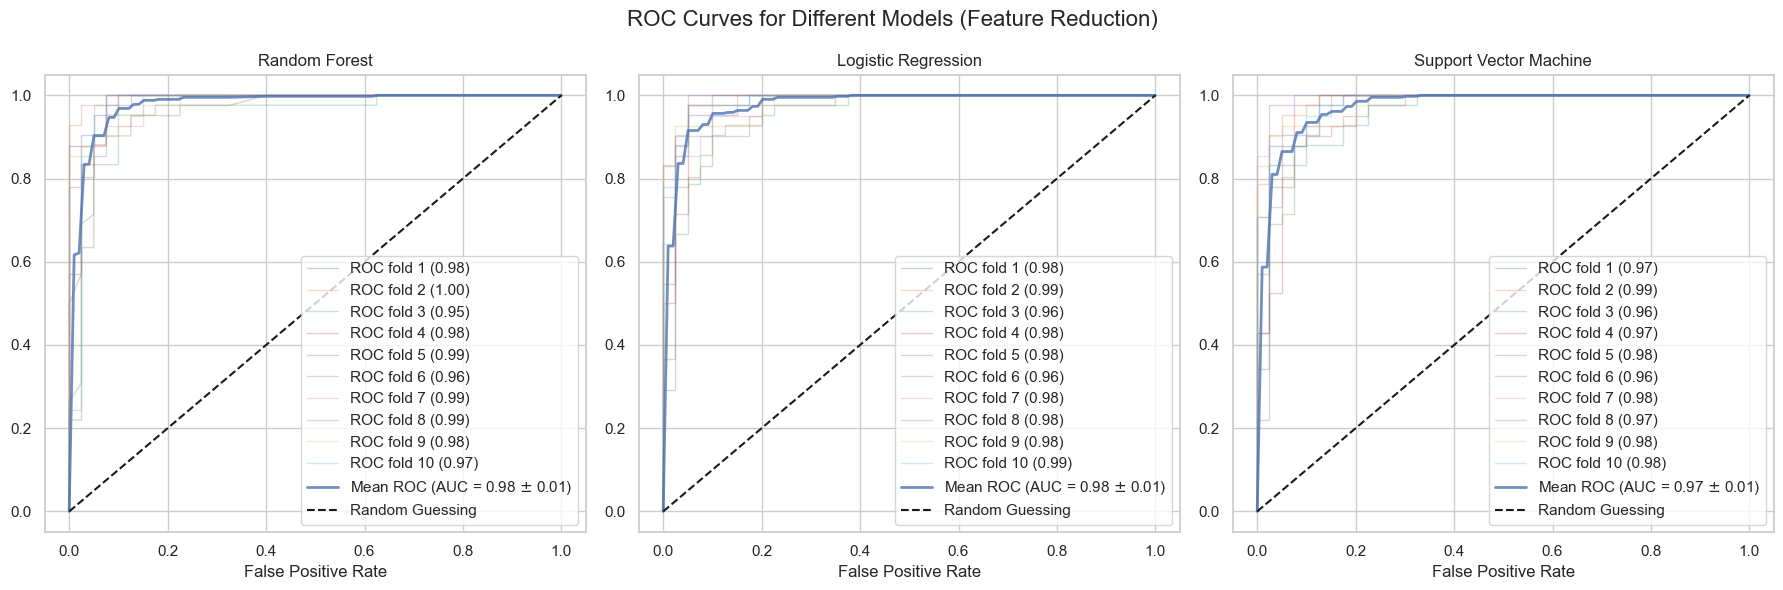

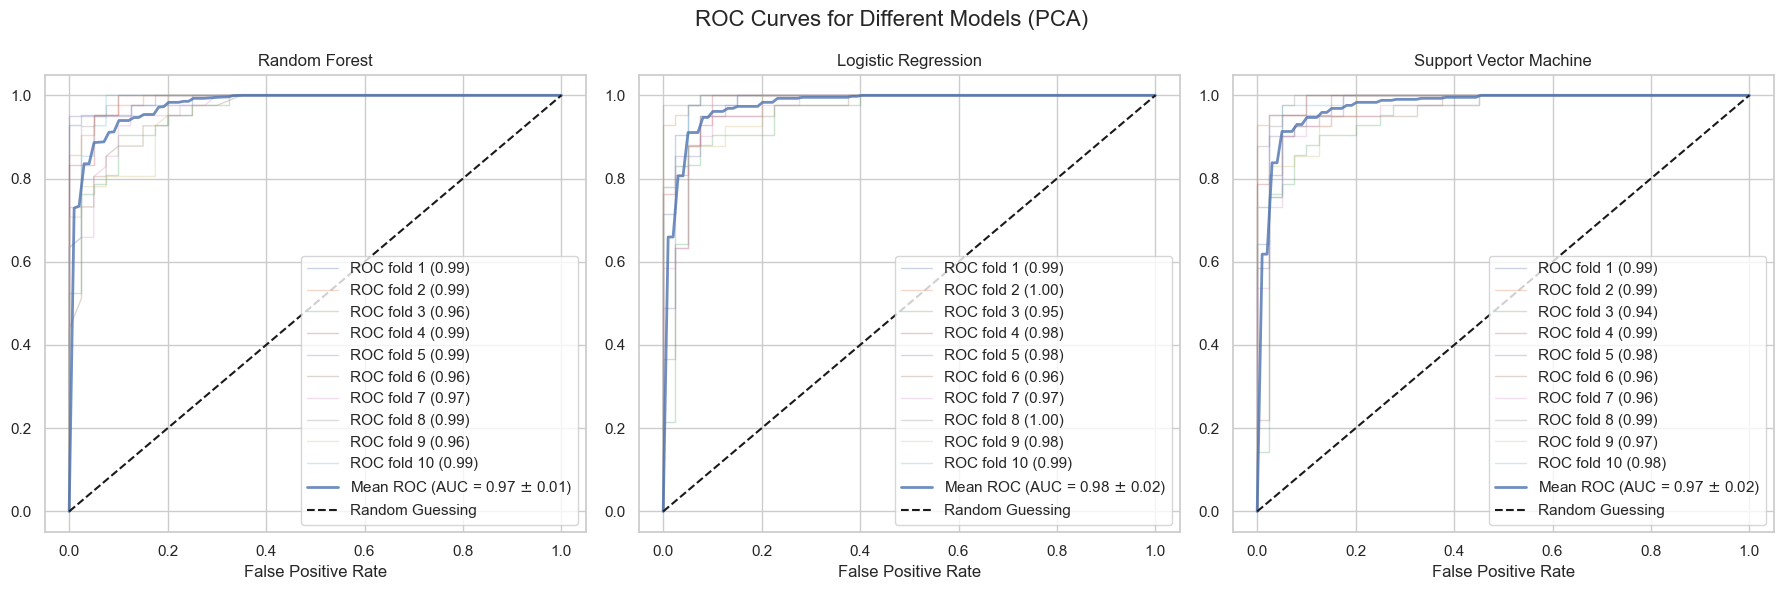

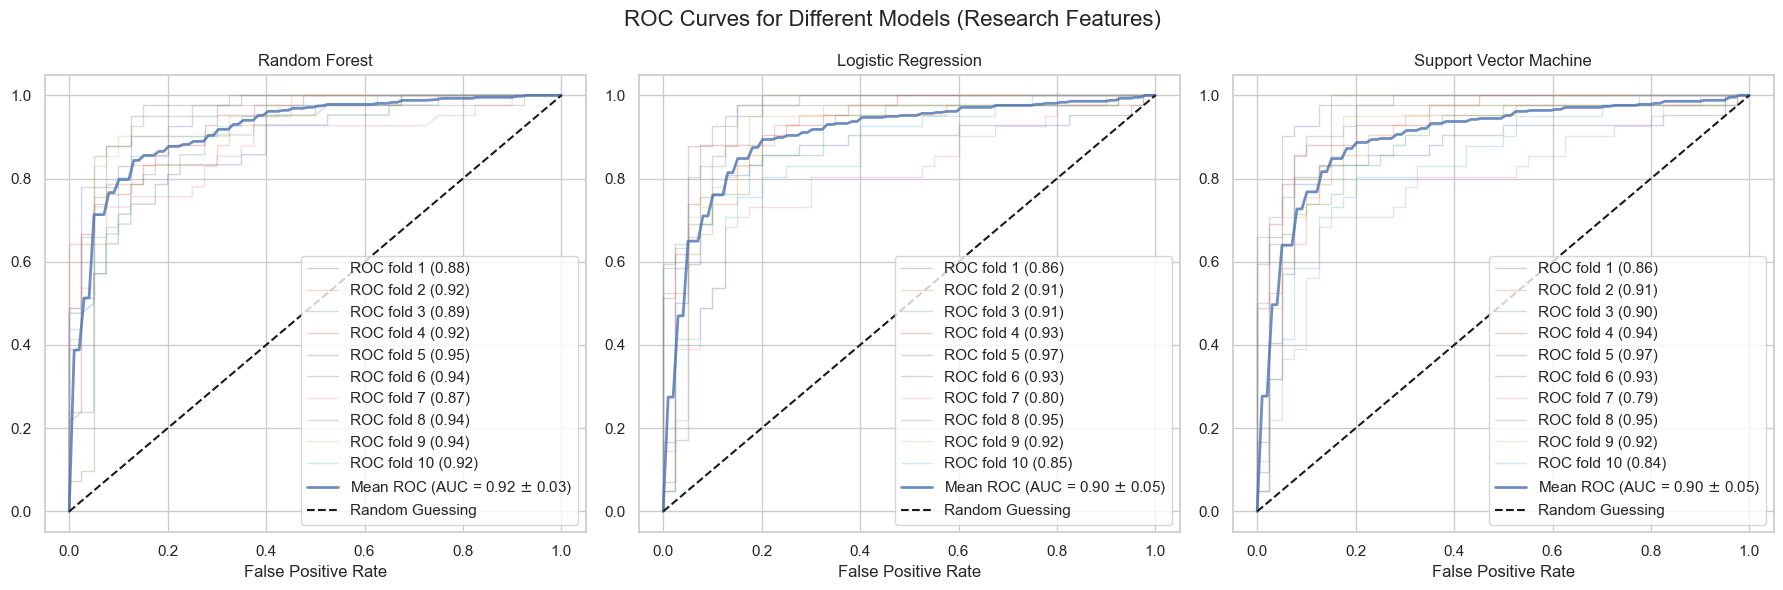

In [ ]:
def plotRocCurve(ax: Axes, results: dict[str: object], name: str = 'ROC Curve', showYLabel: bool = False) -> None:
    from sklearn.metrics import auc
    import numpy as np

    # Keeping track of the tprs and aucs for plotting the mean ROC curve
    tprs: list = []
    aucs: list = []
    baseFpr = np.linspace(0, 1, 100)

    # Retrieving the ROC curves from the results dictionary    
    rocCurves: list = results['roc_curves']

    # Looping through each ROC curve to plot it
    for i, (fpr, tpr, _) in enumerate(rocCurves):
        # Calculatiing the area under the curve (AUC) for statistical analysis
        aucValue: float = auc(fpr, tpr)

        # Plotting each ROC curve
        ax.plot(fpr, tpr, lw=1, alpha=0.3 if len(rocCurves) > 1 else 1, label=f'ROC fold {i + 1} ({aucValue:.2f})')

        # Calculating the AUC for each ROC curve
        aucs.append(aucValue)
        tprInterp = np.interp(baseFpr, fpr, tpr)
        tprInterp[0] = 0.0
        tprs.append(tprInterp)  
    
    # Calculating the average ROC curve and AUC
    meanTpr: list = np.mean(tprs, axis=0)
    meanTpr[-1] = 1.0
    meanAuc: float = auc(baseFpr, meanTpr)
    stdUuc: float = np.std(aucs)

    # Plotting the average ROC curve
    if len(tprs) > 1:
        ax.plot(baseFpr, meanTpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (meanAuc, stdUuc), lw=2, alpha=0.8)

    # Plotting the example random guessing line
    ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    ax.set_xlabel('False Positive Rate')

    # Used for fine control and less redundant labels
    if showYLabel:
        ax.set_ylabel('True Positive Rate')

    # Setting the x and y and placing the legend on an empty part of the plot    
    ax.set_title(name)
    ax.legend(loc='lower right')

# Function to plot ROC curves for different models in a subplot
def plotRocCurvesSubPlot(curves: dict[str, dict], kind: str):
    # Creating a subplot figure with 3 columns for each model's ROC curve
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Title for the entire figure
    fig.suptitle(f'ROC Curves for Different Models ({kind})', fontsize=16)

    # Plotting each ROC curve in its respective subplot
    for i, (modelName, results) in enumerate(curves.items()):
        plotRocCurve(ax[i], results, modelName)

    plt.tight_layout()
    plt.show()

# Plotting the ROC curves for the feature reduction method
plotRocCurvesSubPlot(createDictForFeatureSelection(
    rfReductionResults, logRegReductionResults, svmReductionResults), 'Feature Reduction')

# Plotting the ROC curves for the PCA method
plotRocCurvesSubPlot(createDictForFeatureSelection(
        rfPCAResults, logRegPCAResults, svmPCAResults), 'PCA')

# Plotting the ROC curves for the research features method
plotRocCurvesSubPlot(createDictForFeatureSelection(
    rfResearchResults, logRegResearchResults, svmResearchResults), 'Research Features')

#### 6.5. Classification Reports

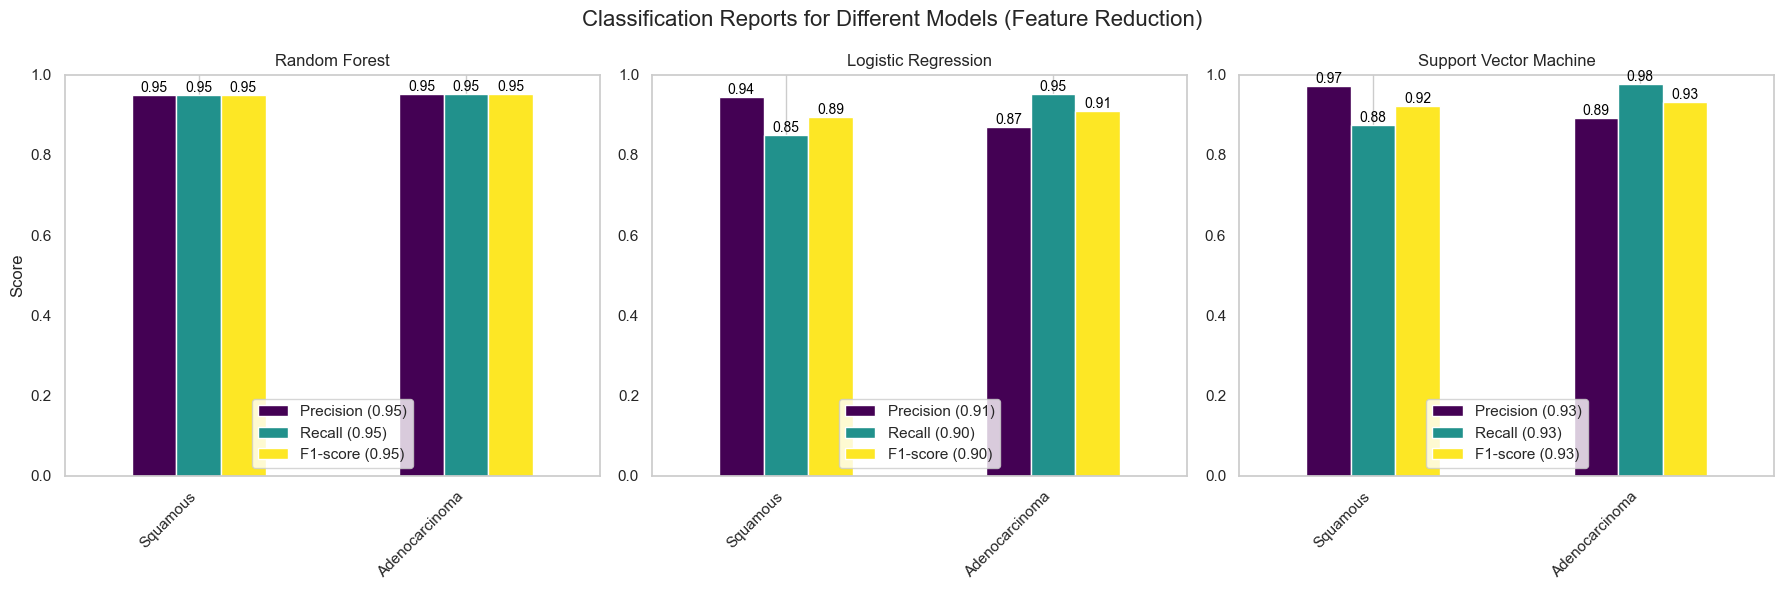

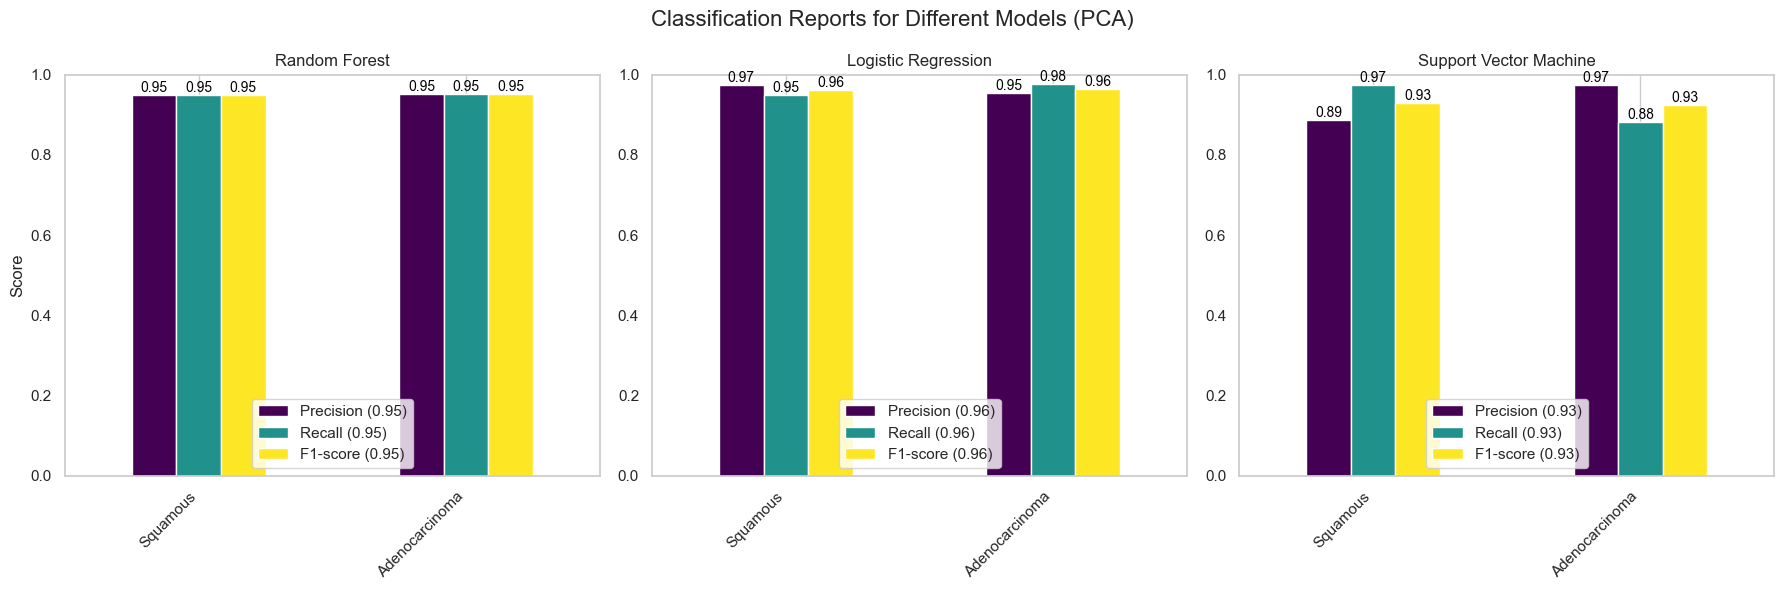

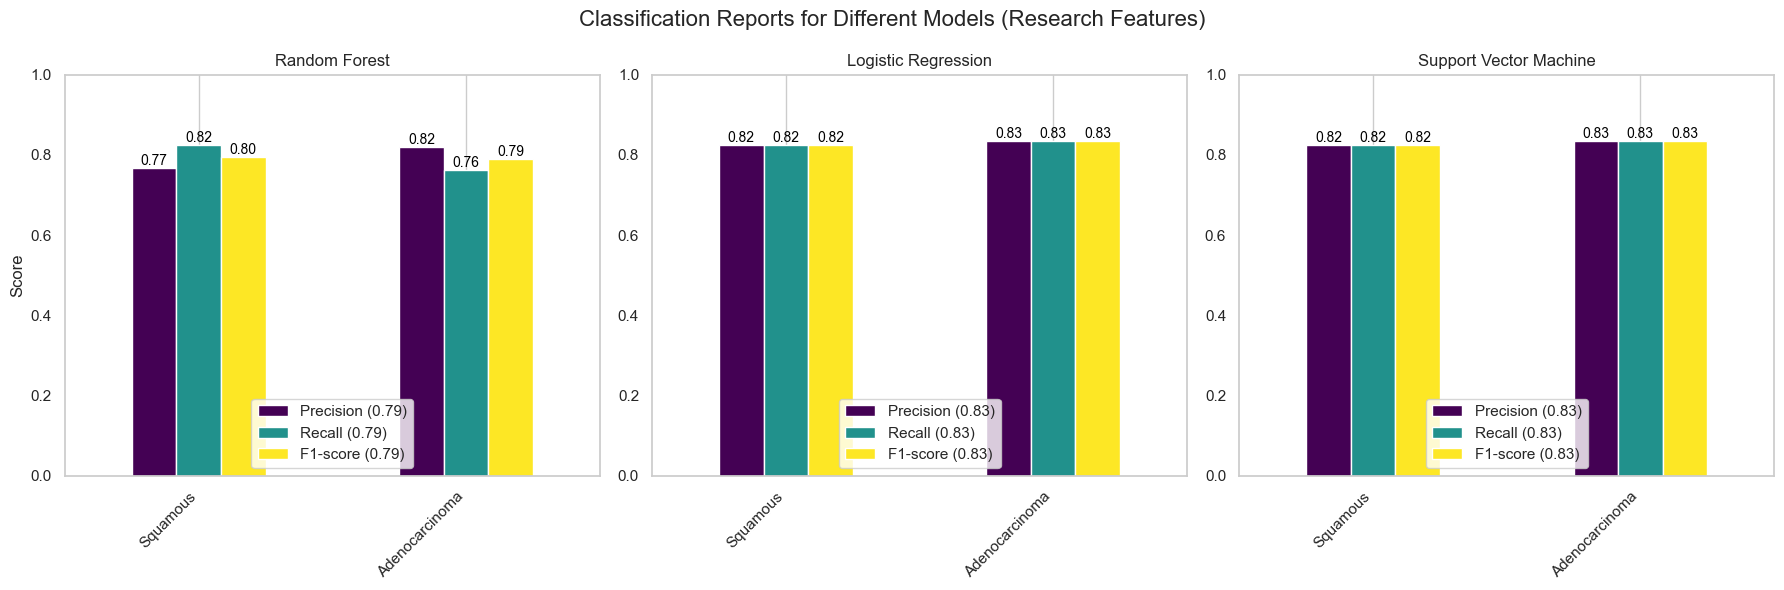

In [ ]:
def plotClassificationReport(ax: Axes, results, name: str = 'Classification Report', showYLabels: bool = False) -> None:
    import pandas as pd

    # This flattens the report into a DataFrame for easy plotting
    reportDataFrame: pd.DataFrame = pd.DataFrame(results['average_classification_report']).T

    # Keep only the desired metrics (ignore 'support')
    plotDataFrame: pd.DataFrame = reportDataFrame.drop(columns=['support'], errors='ignore')

    # Remove aggregate rows if you only want class-specific metrics
    classesOnly: pd.DataFrame = plotDataFrame.loc[~plotDataFrame.index.isin(['accuracy', 'macro avg', 'weighted avg'])]

    # Capitalizing each column name and appending the mean value for each class
    classesOnly.columns = [f"{column.capitalize()} ({classesOnly[column].mean():.2f})" for column in classesOnly.columns]

    # Plot using built-in pandas plotting function
    classesOnly.plot(kind='bar', colormap='viridis', ax=ax)
    ax.set_title(name)

    # Used for fine control and less redundant labels
    if showYLabels:
        ax.set_ylabel('Score')

    # Setting the y scale to be between 0 and 1 to match the classification report scores
    ax.set_ylim(0, 1)

    # Setting the grid to be vertical for better readability
    ax.grid(axis='y')

    # Adding text labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

    # Setting the x-ticks to show the the category names using the categoryNameMap
    ax.set_xticklabels([categoryNameMap.get(int(label), label) for label in classesOnly.index], rotation=45, ha='right')


# Function to plot classification reports for different models in a subplot
def plotClassificationReportsSubPlot(reports: dict[str, dict], kind: str):
    # Creating a subplot figure with 3 columns for each model's ROC curve
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Title for the entire figure
    fig.suptitle(f'Classification Reports for Different Models ({kind})', fontsize=16)

    # Plotting ech classification report in its respective subplot
    for i, (modelName, results) in enumerate(reports.items()):
        plotClassificationReport(ax[i], results, modelName, showYLabels=(i == 0))

    plt.tight_layout()
    plt.show()

# Plotting the classification reports for the feature reduction method
plotClassificationReportsSubPlot(createDictForFeatureSelection(
    rfReductionResults, logRegReductionResults, svmReductionResults), 'Feature Reduction')

# Plotting the classification reports for the PCA method
plotClassificationReportsSubPlot(createDictForFeatureSelection(
        rfPCAResults, logRegPCAResults, svmPCAResults), 'PCA')

# Plotting the classification reports for the research features method
plotClassificationReportsSubPlot(createDictForFeatureSelection(
    rfResearchResults, logRegResearchResults, svmResearchResults), 'Research Features')

#### 6.6. SHAP Visualizations


SHAP Values for Feature Reduction:


<Figure size 640x480 with 0 Axes>

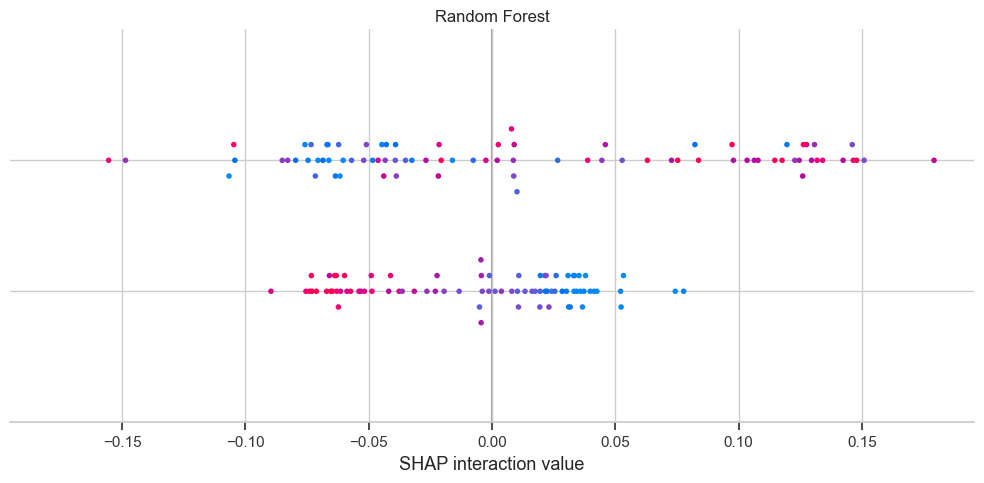

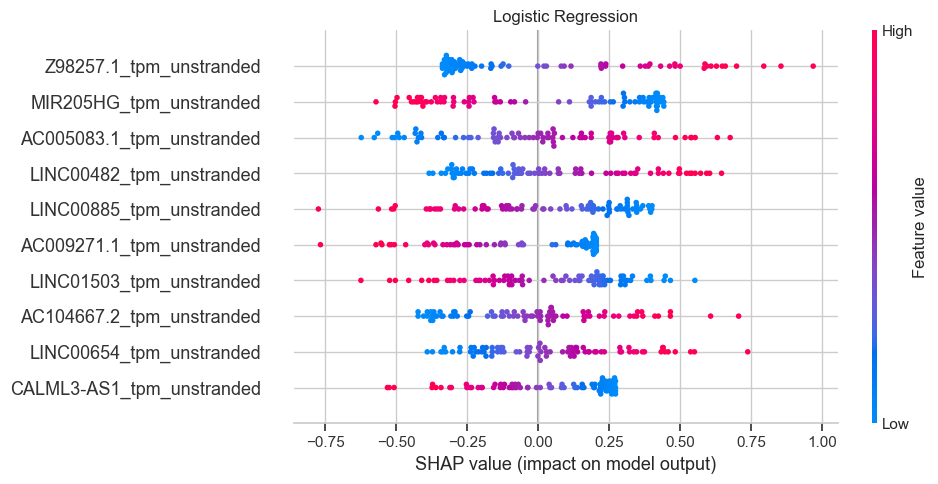

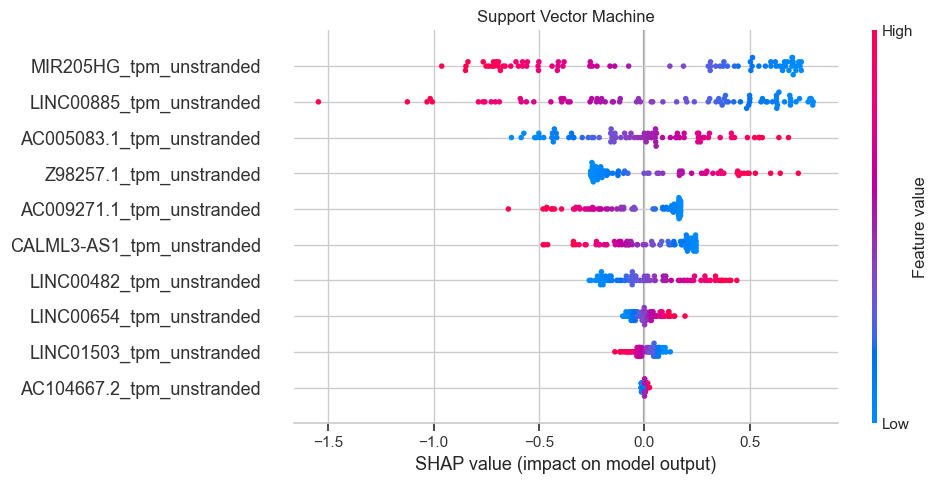


SHAP Values for PCA:


<Figure size 640x480 with 0 Axes>

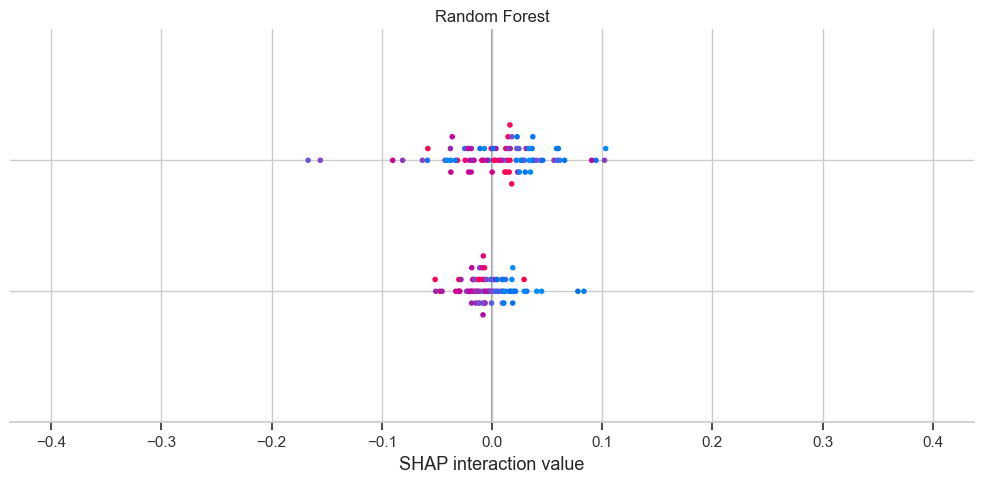

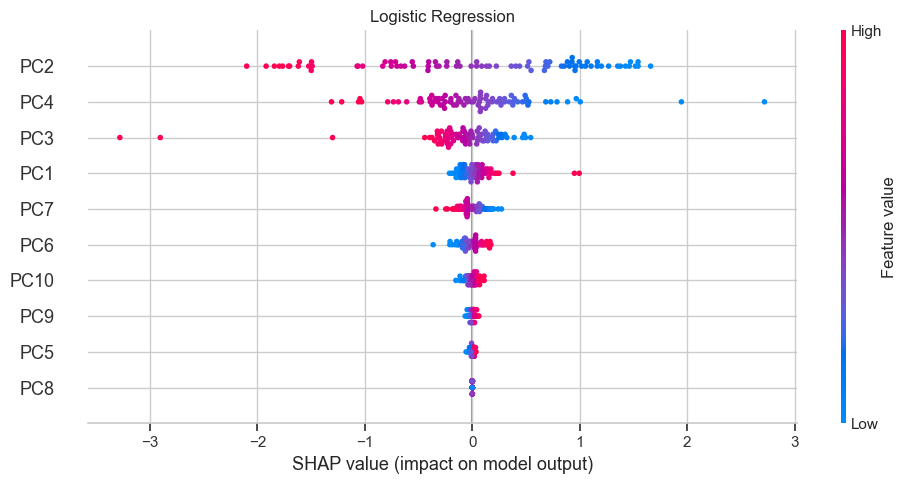

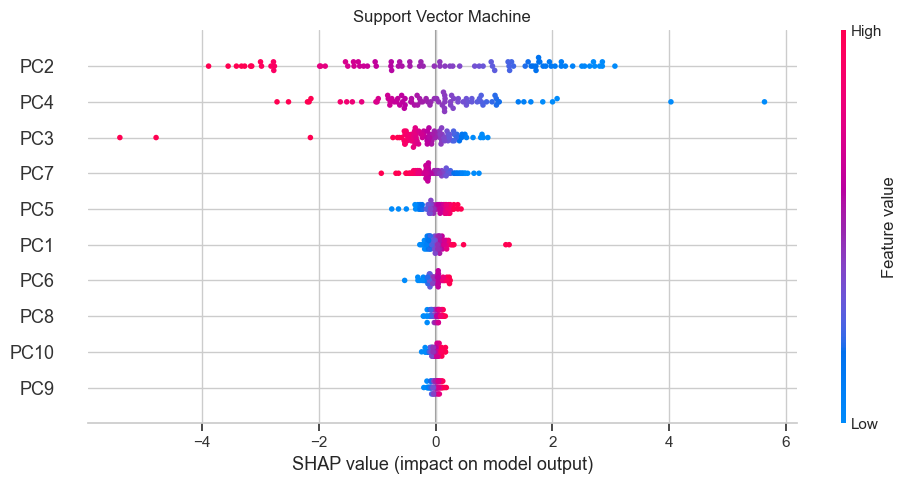


SHAP Values for Research Features:


<Figure size 640x480 with 0 Axes>

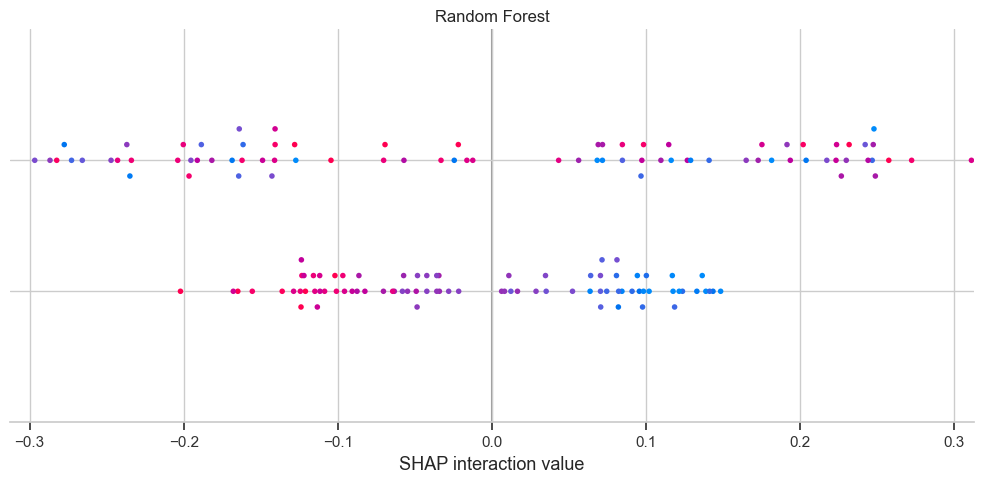

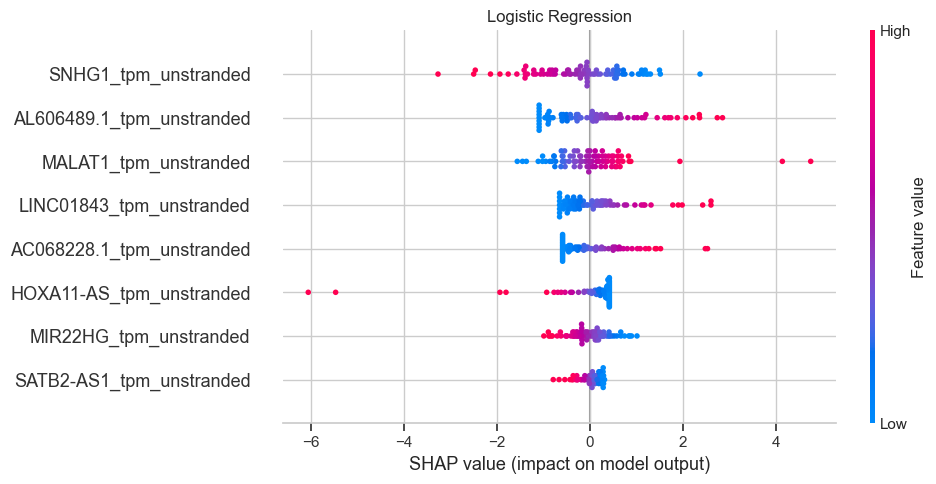

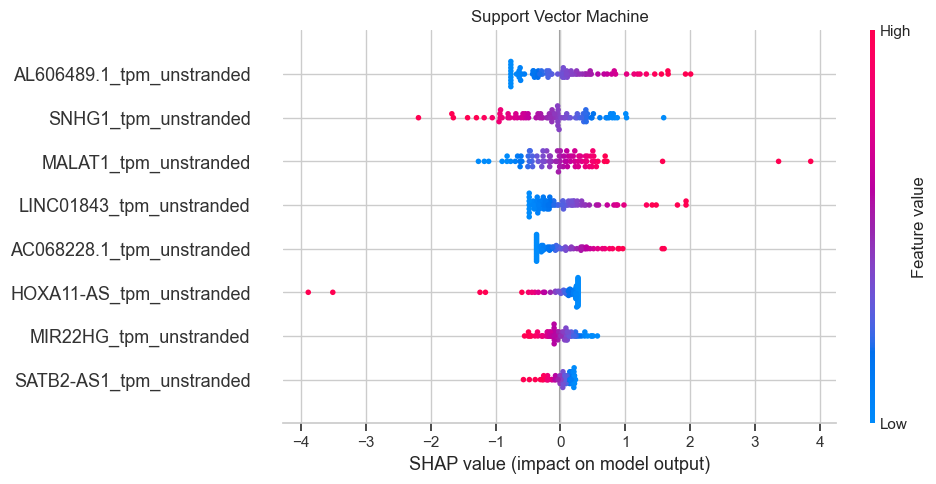

In [ ]:
# Function to plot SHAP values into a given Axes
def plotShapValues( results, name: str = 'SHAP Values') -> None:
    # Verifying that the model has SHAP values available
    avarageShap = results['average_shap_values']
    if avarageShap is None:
        return
    
    # Retrieving the SHAP values and the corresponding test set
    shapValues, X_test = avarageShap
   
    # Plotting the shap values into a dot plot
    shap.summary_plot(shapValues, X_test, plot_type='dot', plot_size=None, show=False)

    # Styling the plots to match in size and appearance
    plt.gcf().set_size_inches(10, 5)
    plt.title(name)
    plt.tight_layout()
    plt.show()

# Function to plot SHAP values for different models in a subplot
def plotShapValuesPlots(shapResults: dict[str, dict], kind: str):
    print(f"\nSHAP Values for {kind}:")
    # Plotting each SHAP value in its respective subplot
    for modelName, results in shapResults.items():
        plotShapValues(results, modelName)

# Plotting SHAP values for feature reduction
plotShapValuesPlots(createDictForFeatureSelection(
    rfReductionResults, logRegReductionResults, svmReductionResults), 'Feature Reduction')

# Plotting SHAP values for PCA
plotShapValuesPlots(createDictForFeatureSelection(
        rfPCAResults, logRegPCAResults, svmPCAResults), 'PCA')

# Plotting SHAP values for research features
plotShapValuesPlots(createDictForFeatureSelection(
    rfResearchResults, logRegResearchResults, svmResearchResults), 'Research Features')